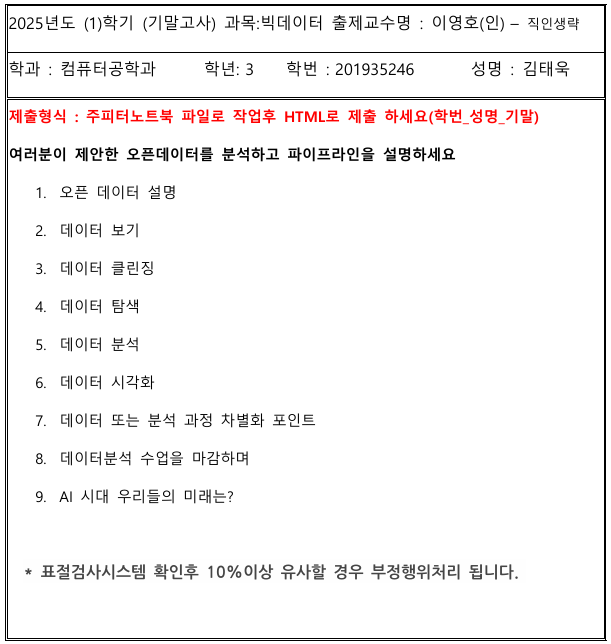

## 🗂️ **1. 오픈 데이터 설명**

### 🎯 **프로젝트 목표**

본 프로젝트는 **Steam 플랫폼에서 유통 중인 게임 데이터를 수집 및 분석**하여,  
**장르, 가격대, 출시일, 리뷰 수, 무료 여부, 한글화 지원** 등의 다양한 특성을 기반으로  
게임 시장에 대한 **통계적 인사이트를 도출하는 것**을 목표로 하였습니다.

---

### 📡 **데이터 수집 과정**

처음에는 **Steam의 공식 API인** `ISteamApps/GetAppList`를 통해  
**총 약 200,000개의 AppID 목록**을 수집하였습니다.

그중 `"type": "game"`으로 분류된 항목만 필터링하여,  
**실제 게임 데이터**에 해당하는 AppID들만을 대상으로 삼았습니다.

예시:

| appid   | name                                         |
|---------|----------------------------------------------|
| 333390  | Tales of Aravorn: Seasons Of The Wolf        |
| 3681000 | 赫夜 -カグヤ-                                  |
| 945360  | Tales of Berseria                            |

이후, 각 AppID에 대해 Steam API를 활용하여  
**출시일, 가격 정보, 장르, 무료 여부** 등의 상세 데이터를 요청하였습니다.

예시 JSON 구조는 다음과 같습니다:

```json
{
  "appid": 333390,
  "name": "Tales of Aravorn: Seasons Of The Wolf",
  "release_date": "15 Jan, 2015",
  "is_free": false,
  "type": "game",
  "genres": [
    {"id": "25", "description": "Adventure"},
    {"id": "23", "description": "Indie"},
    {"id": "3", "description": "RPG"}
  ],
  "price_overview": {
    "currency": "KRW",
    "initial": 2700000,
    "final": 2700000,
    "discount_percent": 0,
    "final_formatted": "₩ 27,000"
  }
}
```

---

### 🧱 **수집 실패 이슈 및 대응**

Steam API는 공식적으로 제공되는 인터페이스이지만,  
**단일 IP에서 과도하게 요청이 발생할 경우, 정상적인 응답이 오지 않거나 연결이 끊기는 현상**이 발생합니다.

실제로도 약 **20,500개의 AppID에 대해 데이터를 성공적으로 수집한 이후**,  
이후부터는 **API 응답 자체가 누락되거나 빈 응답이 지속적으로 발생**하였습니다.(대략 14.5만 개의 App 검사)

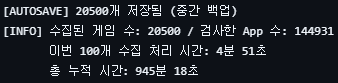

이에 따라, Steam 공식 API를 보완하기 위해
**웹 크롤링 방식**(**BeautifulSoup 및 Selenium 기반**)을 활용하여  
**게임 상세 페이지에서 추가적인 정보와 누락 데이터를 수집하려고 시도**하였습니다.

하지만 이 또한 **Steam 측의 보안 정책으로 인해 IP가 차단**되었으며,  
다음과 같은 오류 메시지를 받았습니다:

> 💥 `HTTP 403 Forbidden – Access Denied`
> 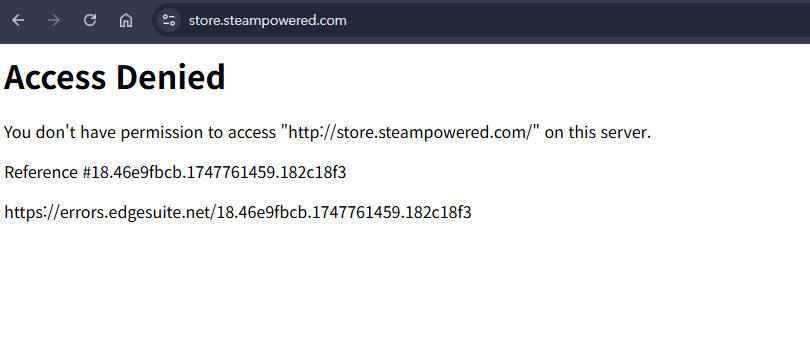

따라서 웹 크롤링 방식은 더 이상 유지하기 어려운 상황이었고,  
결국 **기존에 확보한 약 2만 건의 데이터만을 활용하여 분석을 진행**하기로 결정하였습니다.

---

### ⚠️ **텍스트 인코딩 오류 발견**

수집된 CSV 파일 중 일부에서,  
**게임 이름(`name`) 필드가 텍스트 인코딩 문제로 인해 깨지는 현상**이 발생하였습니다.

예시:

| appid   | name (깨짐)         | name (정상)        |
|---------|----------------------|---------------------|
| 3681000 | 壅ュ쩂 -?ャ궛??       | 赫夜 -カグヤ-        |

---

### ✅ **텍스트 오류 클린징 방식**

이 문제를 해결하기 위해,  
Steam API에서 **`appid`와 `name` 필드만 새로 수집하여 UTF-8-sig로 저장**한 CSV를 생성하였고,  
기존 원시 CSV들과 `appid` 기준으로 **정상적인 게임 이름으로 덮어쓰기 작업**을 수행하였습니다.

사용된 원본 파일 목록은 다음과 같습니다:

- `steam_games_block_1.csv`  
- `steam_games_block_2.csv`  
- `steam_game_data_partial.csv`

수정된 결과 파일은 `data_raw_fixed/` 폴더에 저장되었으며,  
**최종적으로 이 세 파일을 병합하여 `steam_data_fixed_combined.csv`로 통합**하였습니다.

---

**또한 위 데이터 수집 과정을 Github Repository를 만들어 업로드 했습니다.**

**링크 - https://github.com/Kim-TaeWook/steam-analysis**

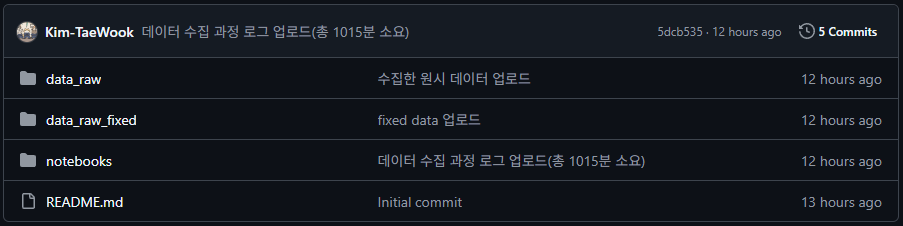

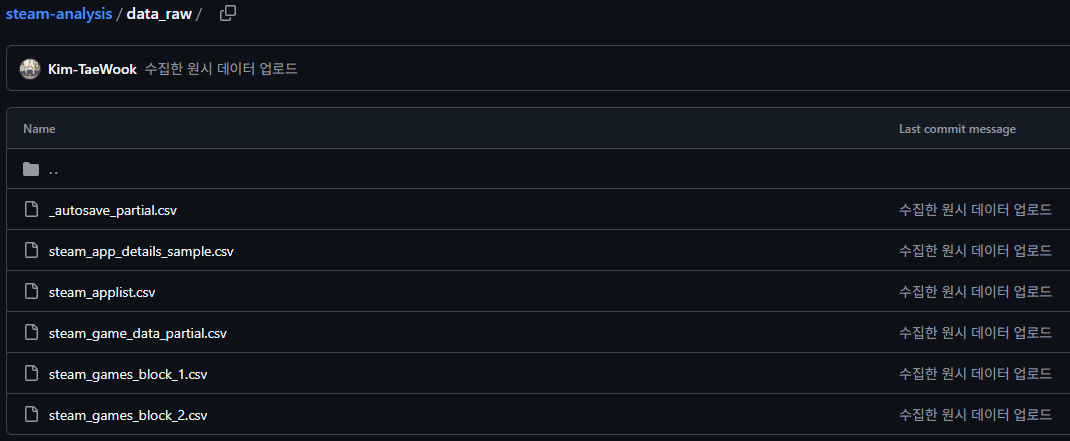

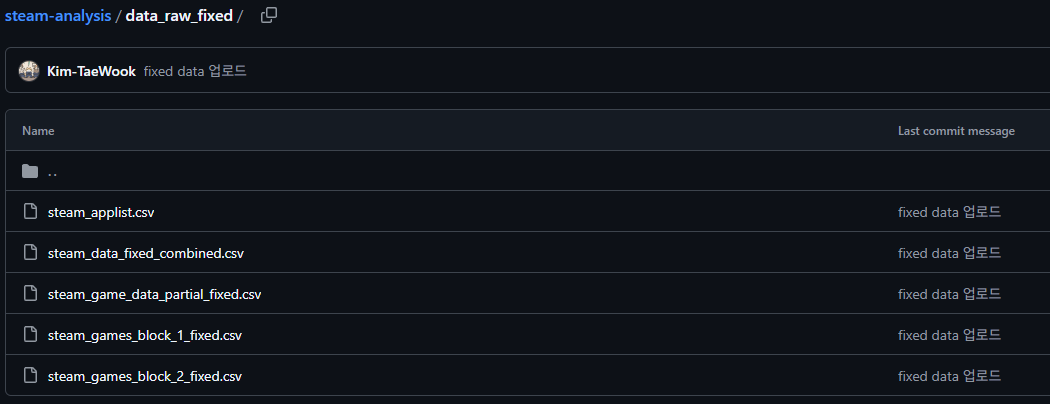

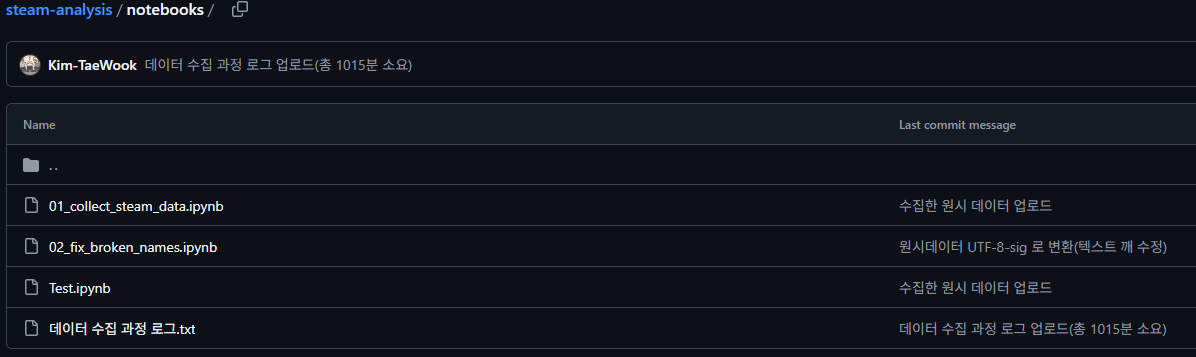

## 🔍 **2. 데이터 보기**

Steam API와 후처리를 통해 확보한 `steam_data_fixed_combined.csv` 파일을 로드하여  
게임 이름, 출시일, 가격, 장르, 무료 여부 등의 주요 필드가 정상적으로 수집되었는지 확인하였습니다.


데이터 분석의 첫 단계는 **원본 데이터를 안전하게 보존하는 것**입니다.  
손상된 데이터는 복구할 수 없기 때문에, 최초 로드한 데이터는 **직접 수정하지 않고 복사본을 활용하여** 이후의 전처리 및 분석 작업을 수행했습니다.

In [5]:
# 필수 라이브러리 불러오기
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
# 깃허브에서 원본 CSV 불러오기 (UTF-8-sig 인코딩 주의)
csv_url = "https://raw.githubusercontent.com/Kim-TaeWook/steam-analysis/refs/heads/main/data_raw_fixed/steam_data_fixed_combined.csv"

# read_csv() 함수로 데이터 프레임 변환
df_raw = pd.read_csv(csv_url, encoding='utf-8-sig')

# 원본 보존 후 복사본 생성
df = df_raw.copy()

# ▶ CSV로 백업 저장
df_raw.to_csv("steam_data_raw_backup.csv", index=False, encoding="utf-8-sig")

# ▶ 저장 확인을 위한 재불러오기 테스트
backup_df = pd.read_csv("steam_data_raw_backup.csv", encoding="utf-8-sig")

# ▶ 백업 데이터 확인
print(f"✅ 백업된 데이터 shape: {backup_df.shape}")
backup_df

✅ 백업된 데이터 shape: (20500, 7)


,appid,name,release_date,is_free,type,genres,price_overview
0,333390,Tales of Aravorn: Seasons Of The Wolf,"15 Jan, 2015",False,game,"[{'id': '25', 'description': 'Adventure'}, {'i...","{'currency': 'KRW', 'initial': 2700000, 'final..."
1,333420,Cossacks 3,"20 Sep, 2016",False,game,"[{'id': '1', 'description': 'Action'}, {'id': ...","{'currency': 'KRW', 'initial': 2100000, 'final..."
2,333430,Sinking Island,"5 Dec, 2014",False,game,"[{'id': '25', 'description': 'Adventure'}]","{'currency': 'KRW', 'initial': 850000, 'final'..."
3,332700,Mike was Cursed,"19 Apr, 2018",False,game,"[{'id': '1', 'description': 'Action'}, {'id': ...","{'currency': 'KRW', 'initial': 1250000, 'final..."
4,332710,1Quest,"3 Dec, 2014",False,game,"[{'id': '23', 'description': 'Indie'}, {'id': ...","{'currency': 'KRW', 'initial': 440000, 'final'..."
...,...,...,...,...,...,...,...
20495,803830,The Snowboard Game,"24 Apr, 2018",False,game,"[{'id': '1', 'description': 'Action'}, {'id': ...","{'currency': 'KRW', 'initial': 1550000, 'final..."
20496,803840,It Could Have Been Me,"19 May, 2019",False,game,"[{'id': '23', 'description': 'Indie'}]","{'currency': 'KRW', 'initial': 110000, 'final'..."
20497,803850,Pixelpunk XL,"20 Apr, 2018",False,game,"[{'id': '1', 'description': 'Action'}, {'id': ...","{'currency': 'KRW', 'initial': 440000, 'final'..."
20498,803870,NickProject,"9 Mar, 2018",False,game,"[{'id': '1', 'description': 'Action'}, {'id': ...","{'currency': 'KRW', 'initial': 220000, 'final'..."


In [7]:
# 데이터 프레임 확인
df

,appid,name,release_date,is_free,type,genres,price_overview
0,333390,Tales of Aravorn: Seasons Of The Wolf,"15 Jan, 2015",False,game,"[{'id': '25', 'description': 'Adventure'}, {'i...","{'currency': 'KRW', 'initial': 2700000, 'final..."
1,333420,Cossacks 3,"20 Sep, 2016",False,game,"[{'id': '1', 'description': 'Action'}, {'id': ...","{'currency': 'KRW', 'initial': 2100000, 'final..."
2,333430,Sinking Island,"5 Dec, 2014",False,game,"[{'id': '25', 'description': 'Adventure'}]","{'currency': 'KRW', 'initial': 850000, 'final'..."
3,332700,Mike was Cursed,"19 Apr, 2018",False,game,"[{'id': '1', 'description': 'Action'}, {'id': ...","{'currency': 'KRW', 'initial': 1250000, 'final..."
4,332710,1Quest,"3 Dec, 2014",False,game,"[{'id': '23', 'description': 'Indie'}, {'id': ...","{'currency': 'KRW', 'initial': 440000, 'final'..."
...,...,...,...,...,...,...,...
20495,803830,The Snowboard Game,"24 Apr, 2018",False,game,"[{'id': '1', 'description': 'Action'}, {'id': ...","{'currency': 'KRW', 'initial': 1550000, 'final..."
20496,803840,It Could Have Been Me,"19 May, 2019",False,game,"[{'id': '23', 'description': 'Indie'}]","{'currency': 'KRW', 'initial': 110000, 'final'..."
20497,803850,Pixelpunk XL,"20 Apr, 2018",False,game,"[{'id': '1', 'description': 'Action'}, {'id': ...","{'currency': 'KRW', 'initial': 440000, 'final'..."
20498,803870,NickProject,"9 Mar, 2018",False,game,"[{'id': '1', 'description': 'Action'}, {'id': ...","{'currency': 'KRW', 'initial': 220000, 'final'..."


In [8]:
# 데이터 프레임의 기본 정보 출력
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20500 entries, 0 to 20499
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   appid           20500 non-null  int64 
 1   name            20498 non-null  object
 2   release_date    20428 non-null  object
 3   is_free         20500 non-null  bool  
 4   type            20500 non-null  object
 5   genres          19475 non-null  object
 6   price_overview  12982 non-null  object
dtypes: bool(1), int64(1), object(5)
memory usage: 981.1+ KB


In [9]:
# 데이터 프레임의 기초 통계 확인
df.describe()

,appid
count,2.050000e+04
mean,1.787407e+06
std,1.027648e+06
min,2.400000e+02
25%,9.472975e+05
50%,1.775245e+06
75%,2.581920e+06
max,3.741950e+06


In [10]:
# 데이터 유형 확인
df.dtypes

appid              int64
name              object
release_date      object
is_free             bool
type              object
genres            object
price_overview    object
dtype: object

In [11]:
# 데이터 행 인덱스 확인
df.loc[0]

appid                                                        333390
name                          Tales of Aravorn: Seasons Of The Wolf
release_date                                           15 Jan, 2015
is_free                                                       False
type                                                           game
genres            [{'id': '25', 'description': 'Adventure'}, {'i...
price_overview    {'currency': 'KRW', 'initial': 2700000, 'final...
Name: 0, dtype: object

---
현재 `release_date`, `genres`, `price_overview` 컬럼은 

다음과 같은 비정형 또는 중첩 구조(문자열/딕셔너리/리스트 형태)를 갖고 있어, 

정렬(Sort), 합계(Sum), 그룹화(GroupBy) 등을 수행하기 전에는 전처리를 진행할 예정입니다.

In [13]:
# 상위 데이터 추출
df.head()

,appid,name,release_date,is_free,type,genres,price_overview
0,333390,Tales of Aravorn: Seasons Of The Wolf,"15 Jan, 2015",False,game,"[{'id': '25', 'description': 'Adventure'}, {'i...","{'currency': 'KRW', 'initial': 2700000, 'final..."
1,333420,Cossacks 3,"20 Sep, 2016",False,game,"[{'id': '1', 'description': 'Action'}, {'id': ...","{'currency': 'KRW', 'initial': 2100000, 'final..."
2,333430,Sinking Island,"5 Dec, 2014",False,game,"[{'id': '25', 'description': 'Adventure'}]","{'currency': 'KRW', 'initial': 850000, 'final'..."
3,332700,Mike was Cursed,"19 Apr, 2018",False,game,"[{'id': '1', 'description': 'Action'}, {'id': ...","{'currency': 'KRW', 'initial': 1250000, 'final..."
4,332710,1Quest,"3 Dec, 2014",False,game,"[{'id': '23', 'description': 'Indie'}, {'id': ...","{'currency': 'KRW', 'initial': 440000, 'final'..."


In [14]:
# 하위 데이터 추출
df.tail()

,appid,name,release_date,is_free,type,genres,price_overview
20495,803830,The Snowboard Game,"24 Apr, 2018",False,game,"[{'id': '1', 'description': 'Action'}, {'id': ...","{'currency': 'KRW', 'initial': 1550000, 'final..."
20496,803840,It Could Have Been Me,"19 May, 2019",False,game,"[{'id': '23', 'description': 'Indie'}]","{'currency': 'KRW', 'initial': 110000, 'final'..."
20497,803850,Pixelpunk XL,"20 Apr, 2018",False,game,"[{'id': '1', 'description': 'Action'}, {'id': ...","{'currency': 'KRW', 'initial': 440000, 'final'..."
20498,803870,NickProject,"9 Mar, 2018",False,game,"[{'id': '1', 'description': 'Action'}, {'id': ...","{'currency': 'KRW', 'initial': 220000, 'final'..."
20499,803890,Police Helicopter Simulator,"8 Nov, 2018",False,game,"[{'id': '1', 'description': 'Action'}, {'id': ...","{'currency': 'KRW', 'initial': 2150000, 'final..."


In [15]:
# 데이터 프레임 인덱스 보기
df.index

RangeIndex(start=0, stop=20500, step=1)

In [16]:
# 행, 열 구조 보기
df.values

array([[333390, 'Tales of Aravorn: Seasons Of The Wolf', '15 Jan, 2015',
        ..., 'game',
        "[{'id': '25', 'description': 'Adventure'}, {'id': '23', 'description': 'Indie'}, {'id': '3', 'description': 'RPG'}]",
        "{'currency': 'KRW', 'initial': 2700000, 'final': 2700000, 'discount_percent': 0, 'initial_formatted': '', 'final_formatted': '₩ 27,000'}"],
       [333420, 'Cossacks 3', '20 Sep, 2016', ..., 'game',
        "[{'id': '1', 'description': 'Action'}, {'id': '25', 'description': 'Adventure'}, {'id': '2', 'description': 'Strategy'}]",
        "{'currency': 'KRW', 'initial': 2100000, 'final': 2100000, 'discount_percent': 0, 'initial_formatted': '', 'final_formatted': '₩ 21,000'}"],
       [333430, 'Sinking Island', '5 Dec, 2014', ..., 'game',
        "[{'id': '25', 'description': 'Adventure'}]",
        "{'currency': 'KRW', 'initial': 850000, 'final': 850000, 'discount_percent': 0, 'initial_formatted': '', 'final_formatted': '₩ 8,500'}"],
       ...,
       [803850, 

## 🧹 **3. 데이터 클린징**


데이터 분석을 진행하기 위해서는 먼저 **날짜, 장르, 가격 정보**와 같이 복합적으로 구성된 열을 분석에 용이한 형태로 정제해야 합니다.  

이번 클린징 과정은 다음 세 가지 작업을 중심으로 진행되었습니다:

---

🔹 **① 출시일 문자열 → datetime 형식 변환**

`release_date` 열은 문자열로 되어 있어 **시계열 정렬**, **출시 연도 분석**, **시간 흐름에 따른 추이 시각화** 등에 활용하기 어렵습니다.  
따라서 `pd.to_datetime()`을 이용해 datetime 형식으로 변환하였습니다.

- `errors='coerce'` 옵션을 사용하여 변환 불가능한 날짜는 `NaT`(결측치)로 처리하였습니다.  
- 이후 연도별 트렌드 분석이나 정렬, 필터링이 가능해집니다.

---

🔹 **② 장르 정보 파싱: 리스트 딕셔너리 → 문자열 목록**

`genres` 열은 아래와 같은 리스트 딕셔너리 형태로 저장되어 있습니다:

```json
[{"id": "25", "description": "Adventure"}, {"id": "23", "description": "Indie"}, {"id": "3", "description": "RPG"}]

이 구조는 분석, 그룹화, 빈도수 추출 등에 적합하지 않으므로 아래와 같이 문자열로 파싱하였습니다:

✅ 복수 장르를 가진 게임도 모두 보존되며  
→ `Adventure, Indie, RPG`처럼 **쉼표로 구분된 문자열**로 변환됩니다.  
→ 추후 `.str.contains()`나 `.value_counts()` 등을 활용한 필터링 및 분석이 가능해집니다.

🔹 **③ 가격 정보 파싱: 딕셔너리 구조 → 최종 가격(숫자)**

`price_overview` 열은 다음과 같은 딕셔너리로 구성되어 있습니다:

```json
{"currency": "KRW", "initial": 2700000, "final": 2700000, "final_formatted": "₩ 27,000"}

---

📌 **전처리 작업 요약**

| 열 이름          | 전처리 후 타입    | 분석 활용 예시                              |
|------------------|-------------------|---------------------------------------------|
| `release_date`   | datetime 타입     | 연도별 출시 트렌드, 출시일 기준 정렬        |
| `genres`         | 쉼표 구분 문자열  | 장르별 그룹 분석, 장르 포함 여부 필터링     |
| `price_overview` | 숫자형 최종 가격 | 평균 가격, 고가/저가 게임 분포 분석        |

해당 전처리를 통해 데이터는 보다 분석 친화적인 형태로 정리되었으며, 이후의 탐색과 시각화에 적절한 기반이 마련되었습니다.

In [20]:
import ast
import missingno as msno

In [21]:
# 변환 전 데이터 개수 확인
df.count()

appid             20500
name              20498
release_date      20428
is_free           20500
type              20500
genres            19475
price_overview    12982
dtype: int64

In [22]:
# 변환 전 결측치 확인
df.isnull().sum()

appid                0
name                 2
release_date        72
is_free              0
type                 0
genres            1025
price_overview    7518
dtype: int64

<Axes: >

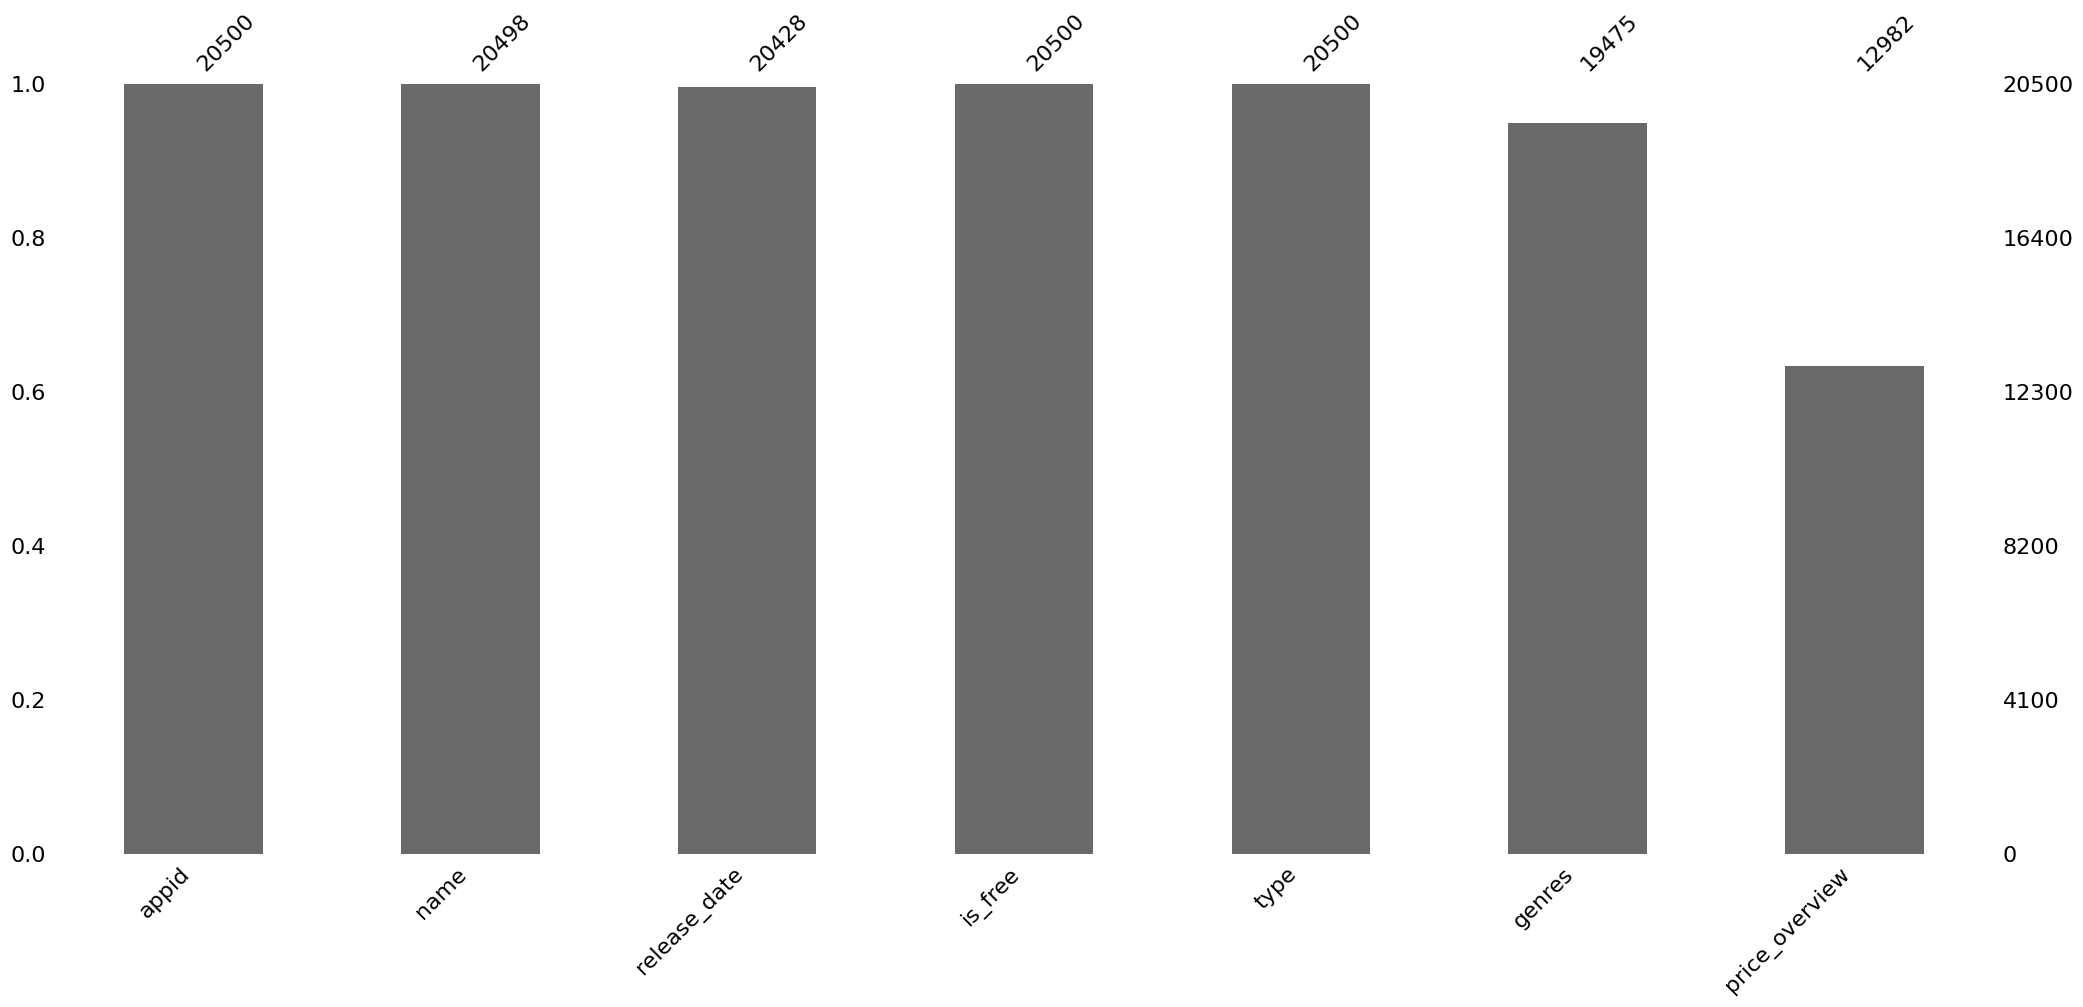

In [23]:
msno.bar(df)

In [24]:
# 1. release_date 문자열 → datetime 변환
df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')

# 변환된 데이터 확인
df

,appid,name,release_date,is_free,type,genres,price_overview
0,333390,Tales of Aravorn: Seasons Of The Wolf,2015-01-15,False,game,"[{'id': '25', 'description': 'Adventure'}, {'i...","{'currency': 'KRW', 'initial': 2700000, 'final..."
1,333420,Cossacks 3,2016-09-20,False,game,"[{'id': '1', 'description': 'Action'}, {'id': ...","{'currency': 'KRW', 'initial': 2100000, 'final..."
2,333430,Sinking Island,2014-12-05,False,game,"[{'id': '25', 'description': 'Adventure'}]","{'currency': 'KRW', 'initial': 850000, 'final'..."
3,332700,Mike was Cursed,2018-04-19,False,game,"[{'id': '1', 'description': 'Action'}, {'id': ...","{'currency': 'KRW', 'initial': 1250000, 'final..."
4,332710,1Quest,2014-12-03,False,game,"[{'id': '23', 'description': 'Indie'}, {'id': ...","{'currency': 'KRW', 'initial': 440000, 'final'..."
...,...,...,...,...,...,...,...
20495,803830,The Snowboard Game,2018-04-24,False,game,"[{'id': '1', 'description': 'Action'}, {'id': ...","{'currency': 'KRW', 'initial': 1550000, 'final..."
20496,803840,It Could Have Been Me,2019-05-19,False,game,"[{'id': '23', 'description': 'Indie'}]","{'currency': 'KRW', 'initial': 110000, 'final'..."
20497,803850,Pixelpunk XL,2018-04-20,False,game,"[{'id': '1', 'description': 'Action'}, {'id': ...","{'currency': 'KRW', 'initial': 440000, 'final'..."
20498,803870,NickProject,2018-03-09,False,game,"[{'id': '1', 'description': 'Action'}, {'id': ...","{'currency': 'KRW', 'initial': 220000, 'final'..."


In [25]:
# 2. genres 리스트 딕셔너리 → 문자열 파싱
def parse_genres(val):
    try:
        genre_list = ast.literal_eval(val)
        return ", ".join([g['description'] for g in genre_list])
    except:
        return None

df['genres_parsed'] = df['genres'].apply(parse_genres)

# 변환된 데이터 확인
df

,appid,name,release_date,is_free,type,genres,price_overview,genres_parsed
0,333390,Tales of Aravorn: Seasons Of The Wolf,2015-01-15,False,game,"[{'id': '25', 'description': 'Adventure'}, {'i...","{'currency': 'KRW', 'initial': 2700000, 'final...","Adventure, Indie, RPG"
1,333420,Cossacks 3,2016-09-20,False,game,"[{'id': '1', 'description': 'Action'}, {'id': ...","{'currency': 'KRW', 'initial': 2100000, 'final...","Action, Adventure, Strategy"
2,333430,Sinking Island,2014-12-05,False,game,"[{'id': '25', 'description': 'Adventure'}]","{'currency': 'KRW', 'initial': 850000, 'final'...",Adventure
3,332700,Mike was Cursed,2018-04-19,False,game,"[{'id': '1', 'description': 'Action'}, {'id': ...","{'currency': 'KRW', 'initial': 1250000, 'final...","Action, Adventure, Indie"
4,332710,1Quest,2014-12-03,False,game,"[{'id': '23', 'description': 'Indie'}, {'id': ...","{'currency': 'KRW', 'initial': 440000, 'final'...","Indie, RPG"
...,...,...,...,...,...,...,...,...
20495,803830,The Snowboard Game,2018-04-24,False,game,"[{'id': '1', 'description': 'Action'}, {'id': ...","{'currency': 'KRW', 'initial': 1550000, 'final...","Action, Indie, Racing, Simulation, Sports"
20496,803840,It Could Have Been Me,2019-05-19,False,game,"[{'id': '23', 'description': 'Indie'}]","{'currency': 'KRW', 'initial': 110000, 'final'...",Indie
20497,803850,Pixelpunk XL,2018-04-20,False,game,"[{'id': '1', 'description': 'Action'}, {'id': ...","{'currency': 'KRW', 'initial': 440000, 'final'...","Action, Indie"
20498,803870,NickProject,2018-03-09,False,game,"[{'id': '1', 'description': 'Action'}, {'id': ...","{'currency': 'KRW', 'initial': 220000, 'final'...","Action, Adventure, Indie"


In [26]:
# 3. price_overview 딕셔너리 → KRW 기준 최종 가격 파싱
def parse_price(val):
    try:
        price_dict = ast.literal_eval(val)
        if price_dict.get("currency") == "KRW":
            return price_dict['final'] / 100
        else:
            return None
    except:
        return None

df['price_krw'] = df['price_overview'].apply(parse_price)

# 변환된 데이터 확인
df

,appid,name,release_date,is_free,type,genres,price_overview,genres_parsed,price_krw
0,333390,Tales of Aravorn: Seasons Of The Wolf,2015-01-15,False,game,"[{'id': '25', 'description': 'Adventure'}, {'i...","{'currency': 'KRW', 'initial': 2700000, 'final...","Adventure, Indie, RPG",27000.0
1,333420,Cossacks 3,2016-09-20,False,game,"[{'id': '1', 'description': 'Action'}, {'id': ...","{'currency': 'KRW', 'initial': 2100000, 'final...","Action, Adventure, Strategy",21000.0
2,333430,Sinking Island,2014-12-05,False,game,"[{'id': '25', 'description': 'Adventure'}]","{'currency': 'KRW', 'initial': 850000, 'final'...",Adventure,8500.0
3,332700,Mike was Cursed,2018-04-19,False,game,"[{'id': '1', 'description': 'Action'}, {'id': ...","{'currency': 'KRW', 'initial': 1250000, 'final...","Action, Adventure, Indie",12500.0
4,332710,1Quest,2014-12-03,False,game,"[{'id': '23', 'description': 'Indie'}, {'id': ...","{'currency': 'KRW', 'initial': 440000, 'final'...","Indie, RPG",4400.0
...,...,...,...,...,...,...,...,...,...
20495,803830,The Snowboard Game,2018-04-24,False,game,"[{'id': '1', 'description': 'Action'}, {'id': ...","{'currency': 'KRW', 'initial': 1550000, 'final...","Action, Indie, Racing, Simulation, Sports",15500.0
20496,803840,It Could Have Been Me,2019-05-19,False,game,"[{'id': '23', 'description': 'Indie'}]","{'currency': 'KRW', 'initial': 110000, 'final'...",Indie,1100.0
20497,803850,Pixelpunk XL,2018-04-20,False,game,"[{'id': '1', 'description': 'Action'}, {'id': ...","{'currency': 'KRW', 'initial': 440000, 'final'...","Action, Indie",4400.0
20498,803870,NickProject,2018-03-09,False,game,"[{'id': '1', 'description': 'Action'}, {'id': ...","{'currency': 'KRW', 'initial': 220000, 'final'...","Action, Adventure, Indie",2200.0


In [27]:
# 데이터 개수 확인
df.count()

appid             20500
name              20498
release_date      15962
is_free           20500
type              20500
genres            19475
price_overview    12982
genres_parsed     19475
price_krw         12378
dtype: int64

In [28]:
# 결측치 확인
df.isnull().sum()

appid                0
name                 2
release_date      4538
is_free              0
type                 0
genres            1025
price_overview    7518
genres_parsed     1025
price_krw         8122
dtype: int64

<Axes: >

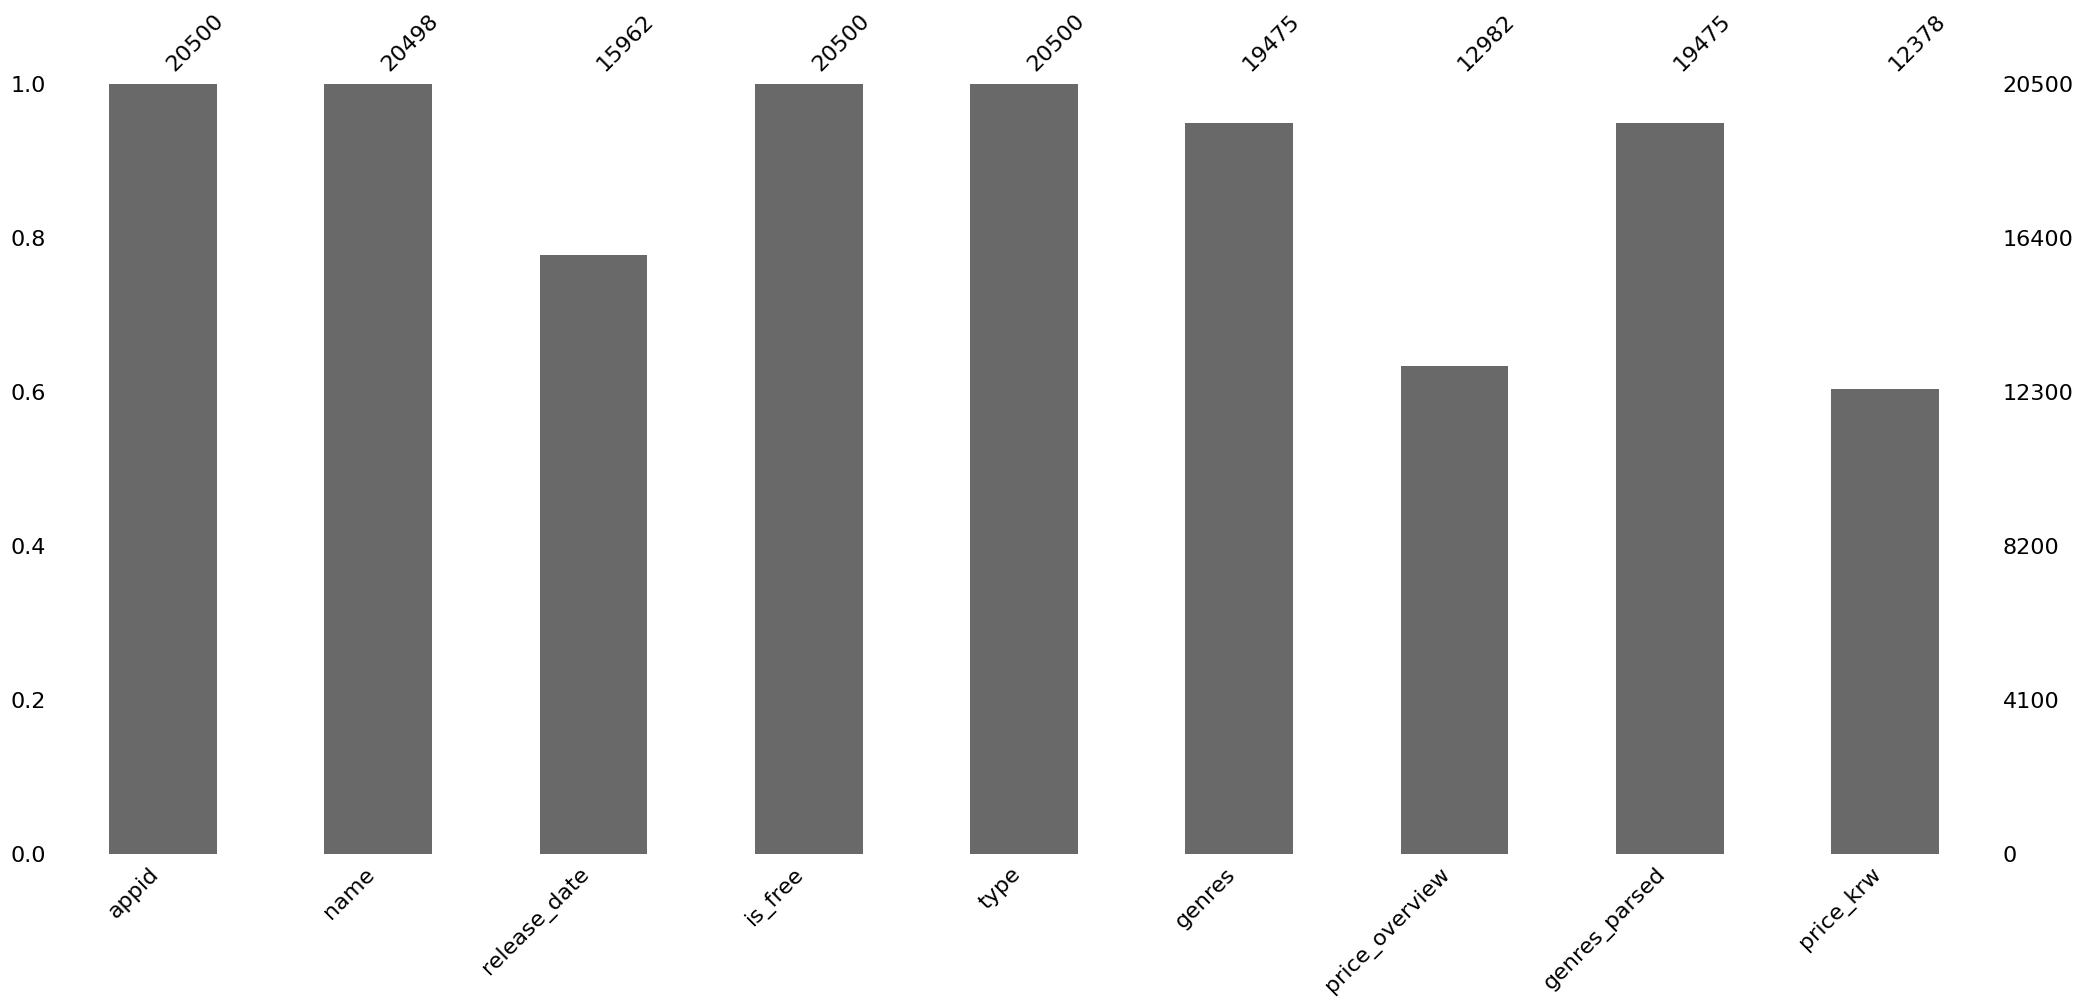

In [29]:
msno.bar(df)

### 🔧 **3-4 추가 전처리: 무료 게임 가격 보정 및 날짜 결측치 제거**

Steam API에서는 `is_free=True`인 게임에 대해 `price_overview` 필드를 제공하지 않는 경우가 많습니다.  
이로 인해 무료 게임임에도 불구하고 가격이 `NaN`으로 표기되는 현상이 발생합니다.  
→ 따라서 `is_free=True`인 경우, `price_krw` 값을 **0.0**으로 보정하여 수치 분석의 일관성을 유지하였습니다.

또한 `release_date`를 `datetime` 형식으로 변환하는 과정에서  
'TBA', 'Coming Soon', 빈 문자열 등 날짜 형식이 아닌 값은 자동으로 **`NaT` (결측값)** 으로 처리됩니다.

이러한 결측치는 단순한 누락이 아닌, **출시되지 않은 게임**임을 의미합니다.  
→ 대부분은 아직 개발 중이거나 상점 페이지만 존재하는 상태이며,  
→ 실제 유저 기반의 통계나 출시일 기반 분석에는 **활용 가치가 매우 낮습니다.**

이에 따라 `release_date`가 없는 게임은 **분석 대상에서 제외**하는 것이 적절하다고 판단하였습니다.

In [31]:
# 무료 게임인 경우 price_krw를 0.0으로 보정
df.loc[df['is_free'] == True, 'price_krw'] = 0.0

# 출시일 결측치(NaT)인 게임 제거
df = df.dropna(subset=['release_date'])

# 처리 결과 확인
print("✅ 보정 후 총 행 수:", len(df))
print("✅ 남아있는 결측치 수:\n", df.isnull().sum())

✅ 보정 후 총 행 수: 15962
✅ 남아있는 결측치 수:
 appid                0
name                 0
release_date         0
is_free              0
type                 0
genres            1009
price_overview    3056
genres_parsed     1009
price_krw         1810
dtype: int64


In [32]:
df

,appid,name,release_date,is_free,type,genres,price_overview,genres_parsed,price_krw
0,333390,Tales of Aravorn: Seasons Of The Wolf,2015-01-15,False,game,"[{'id': '25', 'description': 'Adventure'}, {'i...","{'currency': 'KRW', 'initial': 2700000, 'final...","Adventure, Indie, RPG",27000.0
1,333420,Cossacks 3,2016-09-20,False,game,"[{'id': '1', 'description': 'Action'}, {'id': ...","{'currency': 'KRW', 'initial': 2100000, 'final...","Action, Adventure, Strategy",21000.0
2,333430,Sinking Island,2014-12-05,False,game,"[{'id': '25', 'description': 'Adventure'}]","{'currency': 'KRW', 'initial': 850000, 'final'...",Adventure,8500.0
3,332700,Mike was Cursed,2018-04-19,False,game,"[{'id': '1', 'description': 'Action'}, {'id': ...","{'currency': 'KRW', 'initial': 1250000, 'final...","Action, Adventure, Indie",12500.0
4,332710,1Quest,2014-12-03,False,game,"[{'id': '23', 'description': 'Indie'}, {'id': ...","{'currency': 'KRW', 'initial': 440000, 'final'...","Indie, RPG",4400.0
...,...,...,...,...,...,...,...,...,...
20495,803830,The Snowboard Game,2018-04-24,False,game,"[{'id': '1', 'description': 'Action'}, {'id': ...","{'currency': 'KRW', 'initial': 1550000, 'final...","Action, Indie, Racing, Simulation, Sports",15500.0
20496,803840,It Could Have Been Me,2019-05-19,False,game,"[{'id': '23', 'description': 'Indie'}]","{'currency': 'KRW', 'initial': 110000, 'final'...",Indie,1100.0
20497,803850,Pixelpunk XL,2018-04-20,False,game,"[{'id': '1', 'description': 'Action'}, {'id': ...","{'currency': 'KRW', 'initial': 440000, 'final'...","Action, Indie",4400.0
20498,803870,NickProject,2018-03-09,False,game,"[{'id': '1', 'description': 'Action'}, {'id': ...","{'currency': 'KRW', 'initial': 220000, 'final'...","Action, Adventure, Indie",2200.0


---
### **3-5 분석에 사용할 열 선별**   
분석에 사용하지 않을 appid, type, genres, price_overview 열은 아래와 같이 제거합니다.

In [34]:
# 분석 목적상 사용하지 않을 열 제거
df = df.drop(columns=['appid', 'type', 'genres', 'price_overview'])

# 컬럼 확인
print("📌 현재 컬럼 목록:", df.columns.tolist())

📌 현재 컬럼 목록: ['name', 'release_date', 'is_free', 'genres_parsed', 'price_krw']


In [35]:
df

,name,release_date,is_free,genres_parsed,price_krw
0,Tales of Aravorn: Seasons Of The Wolf,2015-01-15,False,"Adventure, Indie, RPG",27000.0
1,Cossacks 3,2016-09-20,False,"Action, Adventure, Strategy",21000.0
2,Sinking Island,2014-12-05,False,Adventure,8500.0
3,Mike was Cursed,2018-04-19,False,"Action, Adventure, Indie",12500.0
4,1Quest,2014-12-03,False,"Indie, RPG",4400.0
...,...,...,...,...,...
20495,The Snowboard Game,2018-04-24,False,"Action, Indie, Racing, Simulation, Sports",15500.0
20496,It Could Have Been Me,2019-05-19,False,Indie,1100.0
20497,Pixelpunk XL,2018-04-20,False,"Action, Indie",4400.0
20498,NickProject,2018-03-09,False,"Action, Adventure, Indie",2200.0


<Axes: >

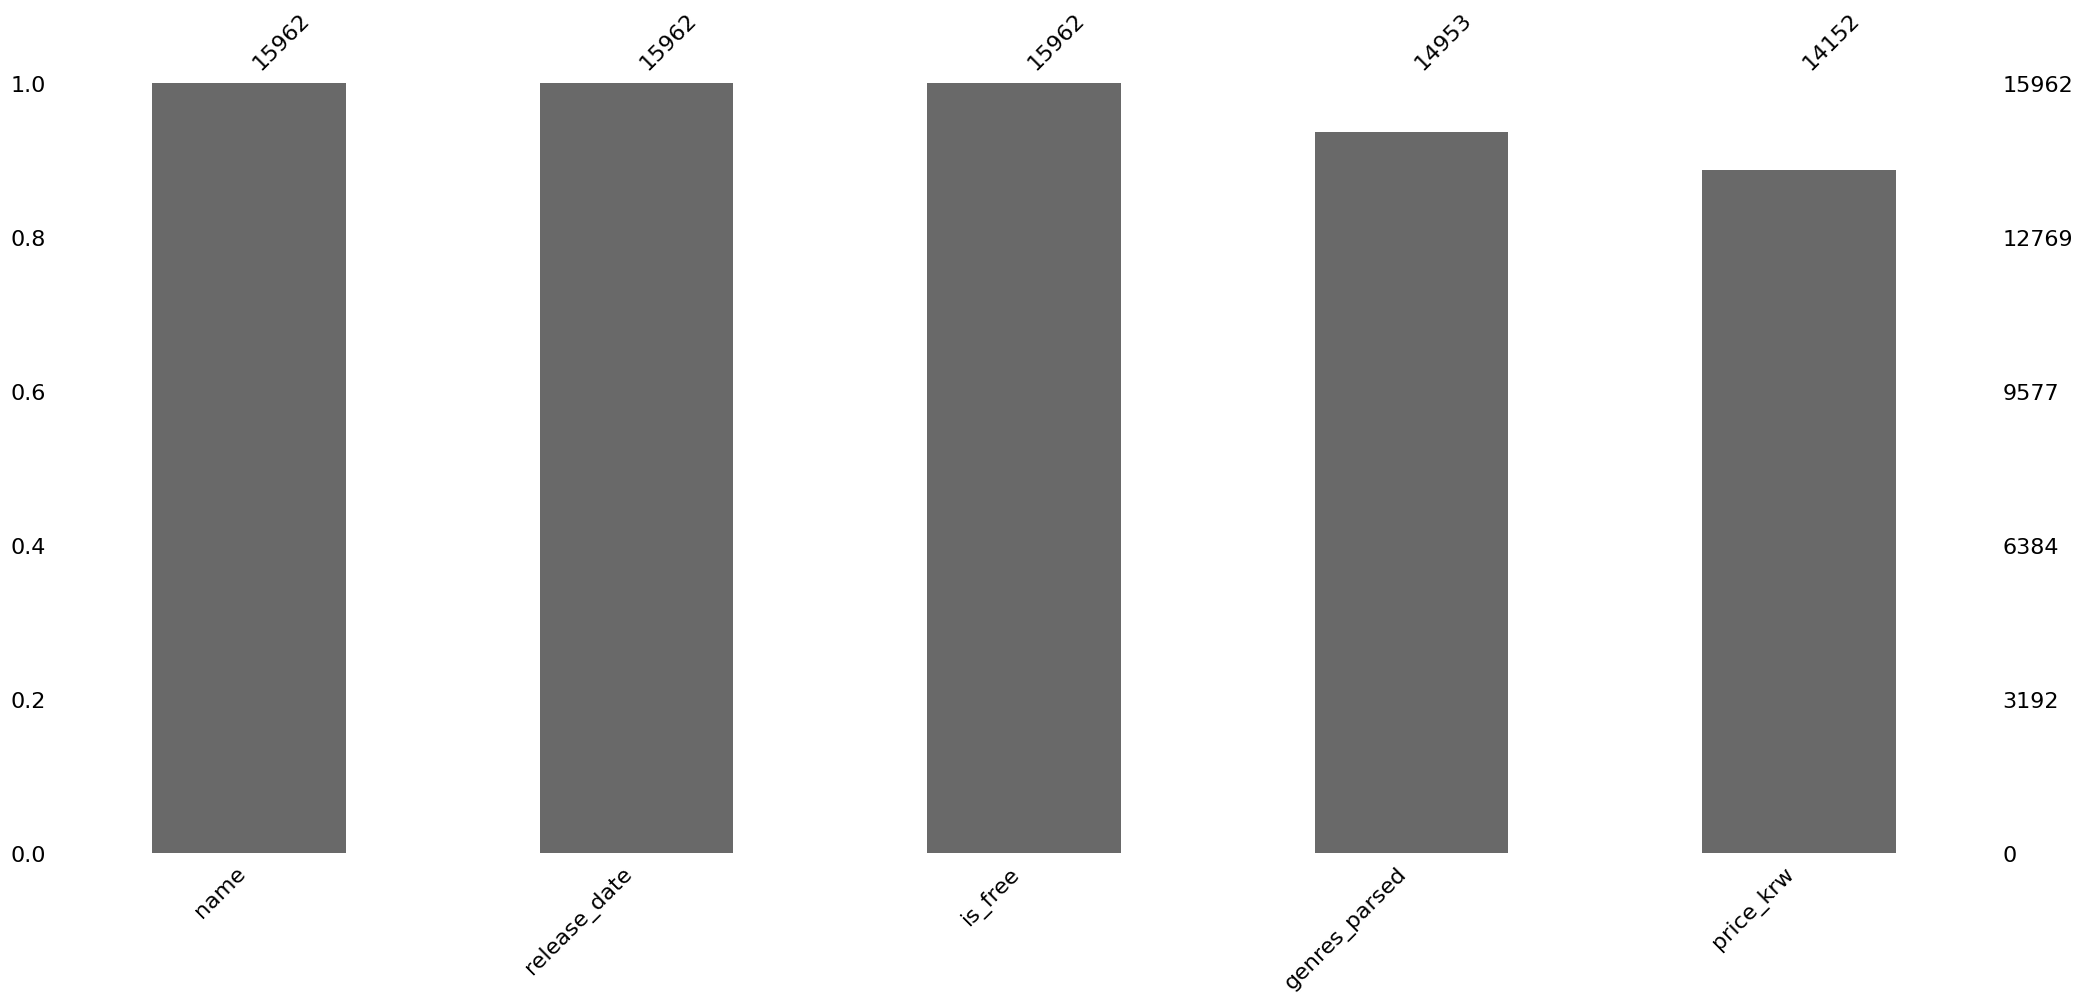

In [36]:
msno.bar(df)

### 🗂️ **3-6. 날짜 정보 분해: `release_date` → 연/월/일**

`release_date`는 시계열 데이터 분석에 매우 중요한 컬럼입니다. 이를 **연도(year)**, **월(month)**, **일(day)**
로 분해하면 다음과 같은 분석이 가능해집니다:

| 파생 컬럼 | 분석 활용 예시 |
|-----------|----------------|
| `release_year` | 연도별 출시 게임 수, 트렌드 파악 |
| `release_month` | 월별 집중 출시 시기 확인 (예: 12월 집중 출시) |
| `release_day` | 요일별 출시 경향 분석 시 활용 가능 (또는 요일 파생 가능) |

이렇게 분해된 컬럼은 이후 `.groupby()`, `.value_counts()`, `.plot()` 등을 통해 **시계열 분석, 계절성 탐색, 출시 전략 분석** 등에 활용할 수 있습니다.

In [38]:
# release_date에서 연도, 월, 일 파생 컬럼 생성
df['release_year'] = df['release_date'].dt.year
df['release_month'] = df['release_date'].dt.month
df['release_day'] = df['release_date'].dt.day

# 변환된 컬럼 확인
df[['release_date', 'release_year', 'release_month', 'release_day']].head()

,release_date,release_year,release_month,release_day
0,2015-01-15,2015,1,15
1,2016-09-20,2016,9,20
2,2014-12-05,2014,12,5
3,2018-04-19,2018,4,19
4,2014-12-03,2014,12,3


In [39]:
df

,name,release_date,is_free,genres_parsed,price_krw,release_year,release_month,release_day
0,Tales of Aravorn: Seasons Of The Wolf,2015-01-15,False,"Adventure, Indie, RPG",27000.0,2015,1,15
1,Cossacks 3,2016-09-20,False,"Action, Adventure, Strategy",21000.0,2016,9,20
2,Sinking Island,2014-12-05,False,Adventure,8500.0,2014,12,5
3,Mike was Cursed,2018-04-19,False,"Action, Adventure, Indie",12500.0,2018,4,19
4,1Quest,2014-12-03,False,"Indie, RPG",4400.0,2014,12,3
...,...,...,...,...,...,...,...,...
20495,The Snowboard Game,2018-04-24,False,"Action, Indie, Racing, Simulation, Sports",15500.0,2018,4,24
20496,It Could Have Been Me,2019-05-19,False,Indie,1100.0,2019,5,19
20497,Pixelpunk XL,2018-04-20,False,"Action, Indie",4400.0,2018,4,20
20498,NickProject,2018-03-09,False,"Action, Adventure, Indie",2200.0,2018,3,9


### 🔍 **3-7 출시 예정 게임 필터링 (2025년 6월 이후)**

Steam에는 아직 출시되지 않은 개발 중 게임도 포함되어 있으며, 이들 중 일부는 `release_date`가 미래 시점으로 설정되어 있습니다.  
특히, **2025년 6월 이후로 설정된 게임들**은 출시 정보가 불확실하거나, 할인/리뷰/가격 등 실제 분석에 필요한 데이터가 부정확할 가능성이 큽니다.

따라서 본 분석에서는 다음 기준으로 **출시 예정 게임을 제거**합니다:

- `release_date`가 **2025년 6월 1일 이후인 경우** → 제거
- 이렇게 정제된 데이터는 **실제 출시된 게임에 대한 분석**에 더욱 적합합니다.


In [41]:
# 🔎 제거 전 확인
print("제거 전 데이터 수:", len(df))
df[['release_date', 'release_year', 'release_month', 'release_day']].head()

# 📅 2025년 6월 1일 이후 출시 예정 게임 제거
cutoff_date = pd.Timestamp('2025-06-01')
df = df[df['release_date'] < cutoff_date].copy()

# 🔎 제거 후 확인
print("제거 후 데이터 수:", len(df))
df[['release_date', 'release_year', 'release_month', 'release_day']].head()

제거 전 데이터 수: 15962
제거 후 데이터 수: 15861


,release_date,release_year,release_month,release_day
0,2015-01-15,2015,1,15
1,2016-09-20,2016,9,20
2,2014-12-05,2014,12,5
3,2018-04-19,2018,4,19
4,2014-12-03,2014,12,3


## 🧭 **4. 데이터 탐색**


본 단계에서는 수집 및 클렌징한 스팀 게임 데이터를 바탕으로 **출시 연도, 가격대, 장르, 유/무료 여부** 등 단변량 중심의 기초 탐색을 진행하였습니다.

또한 `ydata_profiling` 패키지를 활용하여 **자동 탐색 리포트**를 생성하였고, 주요 결측치, 변수 타입, 분포, 이상치 등의 탐색 정보를 확인하였습니다.

📑 **자동 분석 리포트:**
[👉 GitHub에서 확인하기](https://github.com/Kim-TaeWook/steam-analysis/blob/main/steam_game_eda_report.html)

---

### 🔍 **주요 탐색 내용 요약**

- **총 게임 수는 15,861건**이며, 출시 연도 기준으로 **1997년부터 2025년까지** 분포됨
- **출시일이 없는 게임(미출시 예정작)** 및 **2025년 6월 이후 예정 게임**은 분석에서 제외하였음
- **무료 게임은 약 11.1%**, 나머지 **88.9%는 유료 게임**으로 구성되어 있음
- 가격은 **0원을 제외한 유료 게임 기준으로 평균 9,691원**, **5,000원 이하 게임이 가장 많았음**
- **장르 정보는 복수 보유 가능**하며, 가장 흔한 장르는 **Indie, Casual, Action, Adventure**
- 전처리한 `release_date`, `genres_parsed`, `price_krw` 컬럼 기반으로 시계열, 범주형, 수치형 데이터 탐색을 진행함
- **가격대는 사용자 정의 구간**으로 분류하여 **분포 시각화** 진행

---
### 💰 **유료 게임 가격대 분포 (소비자 기준 구간)**

유료 게임 가격을 **소비자의 구매 행동과 스팀 가격 정책**을 반영하여 다음과 같은 구간으로 나누어 분석하였습니다:

| 가격 구간 | 설명 |
|-----------|------|
| ~₩5,000 | 충동구매 구간 – 세일 시 자주 등장, 부담 없는 가격 |
| ~₩12,000 | 인디/중소 구간 – 평균적인 인디 타이틀 가격대 |
| ~₩25,000 | 중간 가격 구간 – AA급 인디, 중형 게임 |
| ~₩45,000 | 정가 게임 구간 – 대부분의 패키지 게임 출시가 |
| ₩45,000~ | 프리미엄 구간 – AAA 타이틀, 디럭스/번들 포함 |

---
🔮 이 탐색 결과는 이후 단계에서의 **장르-가격 관계, 시계열 트렌드, 유료 게임 특성 분석**의 기반으로 사용할 예정입니다.


In [43]:
from ydata_profiling import ProfileReport
# EDA 프로파일링 리포트 생성
profile = ProfileReport(df, title="Steam Game Dataset Report", explorative=True)
profile.to_file("steam_game_eda_report.html")

C:\Users\USER\anaconda3\envs\steam_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Summarize dataset:  67%|███████████████████████▎           | 10/15 [00:00<00:00, 36.04it/s, Calculate auto correlation]C:\Users\USER\anaconda3\envs\steam_env\Lib\site-packages\ydata_profiling\model\pandas\discretize_pandas.py:52: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[6 6 6 ... 7 7 7]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  discretized_df.loc[:, column] = self._discretize_column(
C:\Users\USER\anaconda3\envs\steam_env\Lib\site-packages\ydata_profiling\model\pandas\discretize_pandas.py:52: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0 7 9 ... 2 1 9]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  discretized_df.loc[:, column] = self._discretize_column(
C:\Users\USER\anaconda3\envs\steam_env\Lib\site-packages\ydata_profiling\model\pandas\discret

In [44]:
# 📌 시각화 준비
import matplotlib.font_manager as fm
import platform

# ✅ 한글 폰트 설정
plt.rc('font', family='Malgun Gothic')
plt.rc('axes', unicode_minus=False)

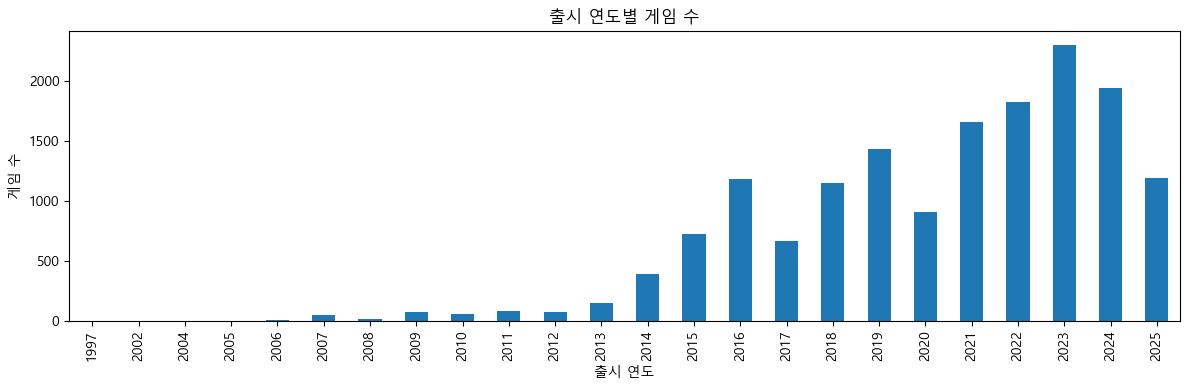

In [45]:
# 🔎 출시 연도별 게임 수
df['release_year'] = df['release_date'].dt.year
df['release_year'].value_counts().sort_index().plot(kind='bar', figsize=(12, 4), title='출시 연도별 게임 수')
plt.xlabel("출시 연도")
plt.ylabel("게임 수")
plt.tight_layout()
plt.show()

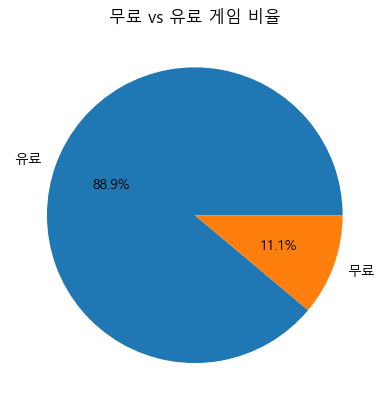

In [46]:
# 🔎 무료 vs 유료 게임 비율
df['is_free'].value_counts().plot(kind='pie', autopct='%1.1f%%', labels=['유료', '무료'], title='무료 vs 유료 게임 비율')
plt.ylabel("")
plt.show()

In [93]:
# 사용자 정의 가격대 정의
price_bins = [0, 5000, 12000, 25000, 45000, float('inf')]
price_labels = [
    "~₩5,000 (충동구매)",
    "~₩12,000 (인디/중소)",
    "~₩25,000 (중간 가격)",
    "~₩45,000 (정가 게임)",
    "₩45,000~ (프리미엄)"
]

# 유료이며 가격 0 이상 필터
paid_df = df[(df['is_free'] == False) & (df['price_krw'] > 0)].copy()

# 새로운 구간으로 나누기
paid_df['price_range'] = pd.cut(paid_df['price_krw'], bins=price_bins, labels=price_labels, right=True)

# 구간별 평균 가격 출력
overall_avg_price = paid_df['price_krw'].mean().round(2)
price_avg_by_range = paid_df.groupby('price_range', observed=True)['price_krw'].mean().round(2)

print("🎯 전체 유료 게임 평균 가격:", overall_avg_price, "KRW\n")
print("📊 소비자 기준 가격 구간별 평균 가격:")
print(price_avg_by_range)

🎯 전체 유료 게임 평균 가격: 9691.27 KRW

📊 소비자 기준 가격 구간별 평균 가격:
price_range
~₩5,000 (충동구매)        2401.30
~₩12,000 (인디/중소)      7949.94
~₩25,000 (중간 가격)     17290.99
~₩45,000 (정가 게임)     31611.62
₩45,000~ (프리미엄)     106915.06
Name: price_krw, dtype: float64


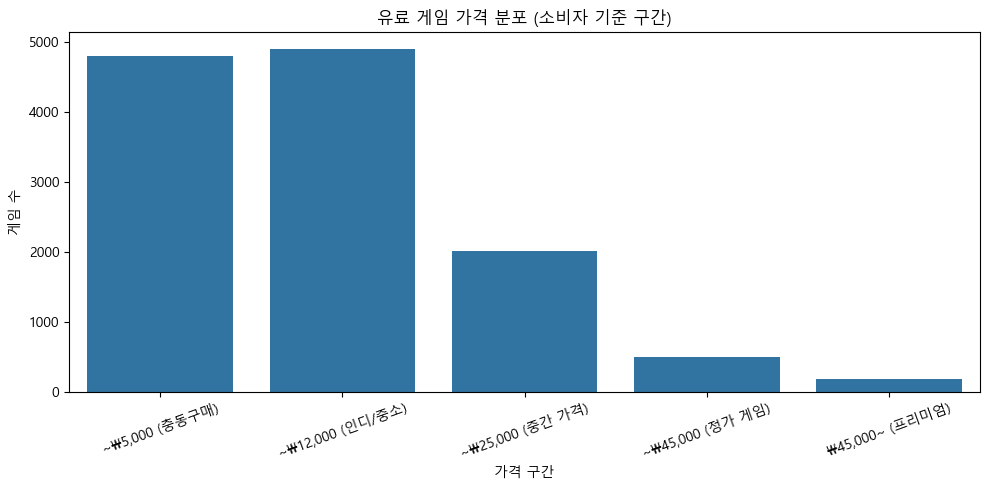

In [95]:
plt.figure(figsize=(10, 5))
sns.countplot(data=paid_df, x='price_range', order=price_labels)
plt.title("유료 게임 가격 분포 (소비자 기준 구간)")
plt.xlabel("가격 구간")
plt.ylabel("게임 수")
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()

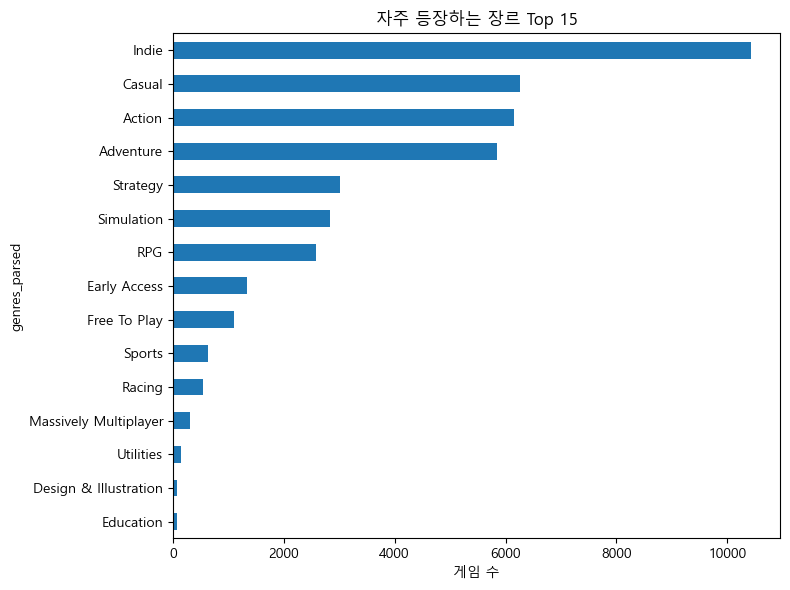

In [49]:
# 🔎 장르별 빈도수
top_genres = df['genres_parsed'].dropna().str.split(', ').explode().value_counts().head(15)
top_genres.plot(kind='barh', title='자주 등장하는 장르 Top 15', figsize=(8, 6))
plt.xlabel("게임 수")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## 📊 **5. 데이터 분석**


전처리된 Steam 게임 데이터를 활용하여 변수 간 관계를 다각도로 분석하였습니다.

분석은 **변수 유형 조합별**로 구성되며, 아래와 같은 흐름으로 진행되었습니다:

---

### 🔢 **분석 흐름**

| 단계 | 분석 유형            | 설명 |
|------|---------------------|------|
| 1️⃣  | 범주형-연속형 분석   | 장르별 평균 가격 분석 |
| 2️⃣  | 범주형-범주형 분석   | 장르별 무료/유료 비율 비교 |
| 3️⃣  | 연속형-연속형 분석   | 출시연도와 가격 간의 상관관계 |

### 💰 1️⃣ **범주형-연속형 분석: 장르별 평균 가격 (Top 10 / Bottom 10)**

장르별로 평균 게임 가격을 계산한 뒤, 상위 10개와 하위 10개의 장르를 분리하여 분석하였습니다.

- `genres_parsed`를 explode하여 다중 장르를 단일 분석 단위로 정제
- 비게임성 태그(Free To Play, Utilities 등)는 사전에 제거
- 평균 가격 기준으로 높은 장르와 낮은 장르를 각각 시각화

이를 통해 고가/저가 장르군의 경향성과 특성을 비교할 수 있습니다.

---

### ⚠️ **장르 정제 기준**

Steam의 `genres` 태그에는 게임 외적인 유틸리티, 툴, 콘텐츠 유형이 혼합되어 있습니다.

분석의 정확성을 위해 아래 항목들은 **비게임 장르(non_game_genres)** 로 판단하여 제외하였습니다.

- `Utilities`, `Software Training`, `Photo Editing`, `Design & Illustration`
- `Animation & Modeling`, `Video Production`, `Game Development`, `Audio Production`, `Education`, `Free To Play`, `Early Access`

---

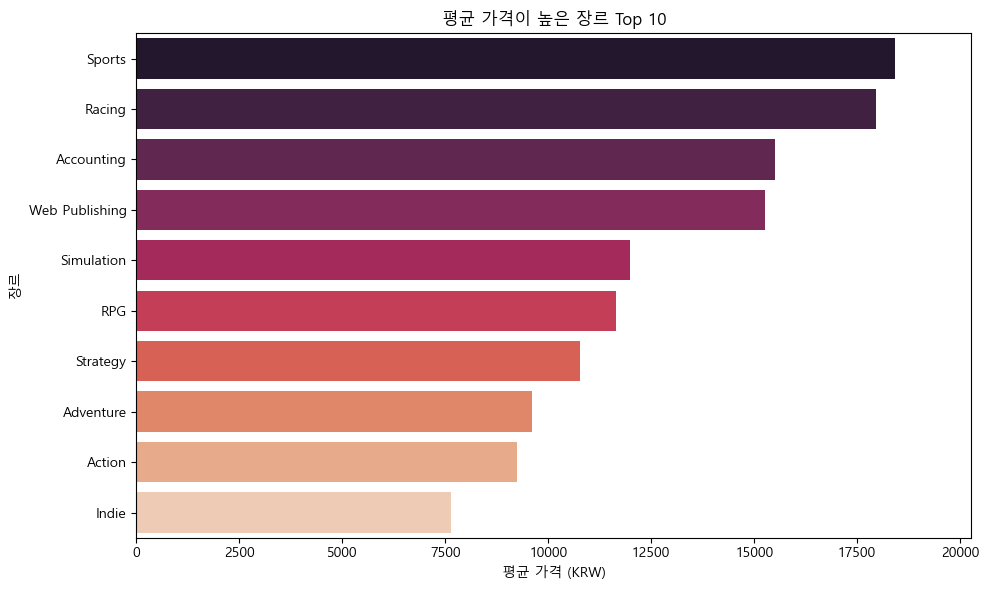

In [249]:
# explode + 정제
genre_price_df = df.copy()
genre_price_df['genres_parsed'] = genre_price_df['genres_parsed'].str.split(', ')
genre_price_df = genre_price_df.explode('genres_parsed')

# 비게임 장르 제거
non_game_genres = [
    "Free To Play", "Early Access", "Utilities", "Education", "Photo Editing", "Video Production",
    "Software Training", "Animation & Modeling", "Design & Illustration", "Game Development", 
    "Audio Production"
]
genre_price_df = genre_price_df[~genre_price_df['genres_parsed'].isin(non_game_genres)]

# 평균 가격 계산
genre_avg_price = genre_price_df.groupby('genres_parsed')['price_krw'].mean().round(2).sort_values(ascending=False)
# 평균 가격 Top 10
genre_avg_top10 = genre_avg_price.head(10).reset_index()
genre_avg_top10.columns = ['genre', 'avg_price']

# 최대값 (상한선 기준)
xmax = genre_avg_top10['avg_price'].max() * 1.1  # 약간의 여유

# 시각화
plt.figure(figsize=(10, 6))
sns.barplot(
    data=genre_avg_top10,
    x='avg_price',
    y='genre',
    palette='rocket',
    hue='genre',
    legend=False
)
plt.xlim(0, xmax)
plt.title("평균 가격이 높은 장르 Top 10")
plt.xlabel("평균 가격 (KRW)")
plt.ylabel("장르")
plt.tight_layout()
plt.show()

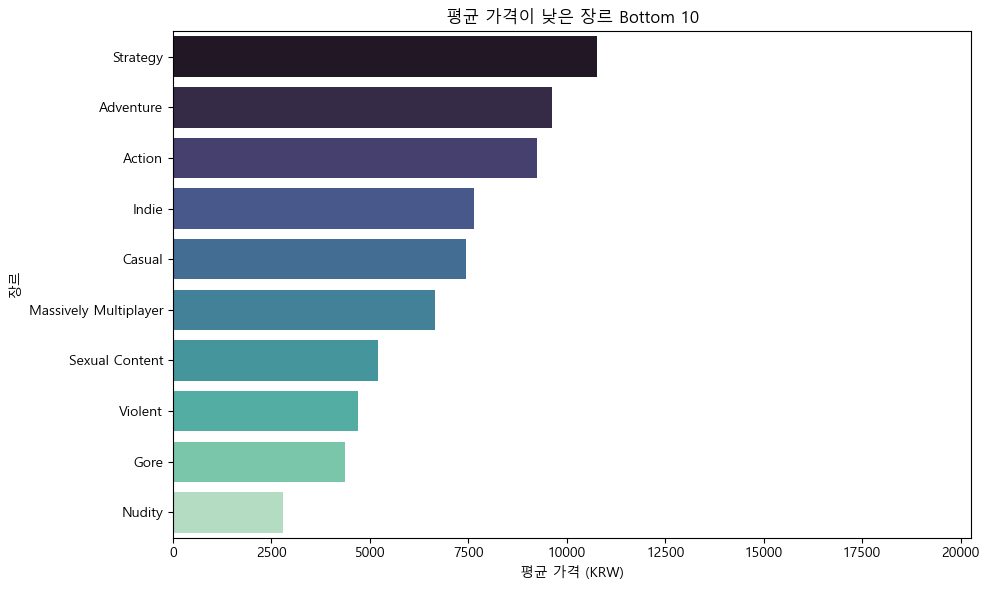

In [255]:
# 평균 가격 Bottom 10
genre_avg_bottom10 = genre_avg_price.tail(10).reset_index()
genre_avg_bottom10.columns = ['genre', 'avg_price']

# 시각화
plt.figure(figsize=(10, 6))
sns.barplot(
    data=genre_avg_bottom10,
    x='avg_price',
    y='genre',
    palette='mako',
    hue='genre',
    legend=False
)
plt.xlim(0, xmax)  # 동일한 x축 범위 적용
plt.title("평균 가격이 낮은 장르 Bottom 10")
plt.xlabel("평균 가격 (KRW)")
plt.ylabel("장르")
plt.tight_layout()
plt.show()


### 📊 2️⃣ **범주형-범주형 분석: 장르별 무료/유료 비율**

게임의 유/무료 여부가 특정 장르군에 몰려 있는지 여부를 분석하였습니다.

예를 들어, **Massively Multiplayer** 또는 **Education** 태그는 비교적 무료 게임 비율이 높은 경향을 보일 수 있습니다.

이를 분석하기 위해 다음과 같은 과정으로 진행하였습니다:

- `genres_parsed` 컬럼을 개별 장르로 분해한 뒤, `is_free` 여부에 따라 무료/유료 비율을 계산
- 게임이 아닌 유틸리티 및 툴 성격의 태그(예: Free To Play, Early Access, Education 등)는 분석 대상에서 제외
- 무료 비율이 높은 장르와 유료 비율이 높은 장르를 각각 시각화하여 비교

---

### ⚠️ **장르 정제 이슈 및 대응**

일부 장르는 실제 게임 장르가 아닌 **도구, 유틸리티, 콘텐츠 태그** 등이 포함되어 있었습니다:

- 예: `Utilities`, `Software Training`, `Photo Editing`, `Audio Production`, `Nudity` 등

이는 Steam 내 `type=game`으로 분류되어 있더라도 태그 수준에서 분류 혼선이 발생하기 때문입니다.

#### 🧹 **대응 방안:**
- 분석 목적에 맞지 않는 장르들을 `non_game_genres` 리스트로 정의
- `genres_parsed` 기준으로 필터링하여 **순수 게임 장르 중심의 분석**으로 정제

---

### 🎯 **분석 결과 요약**

- **무료 비율이 높은 상위 10개 장르**는 캐주얼 게임, 교육용 게임, 에로틱 콘텐츠 중심 장르 등이 포함됨
- **유료 비율이 높은 상위 10개 장르**는 전략, 시뮬레이션, 스포츠 등 콘텐츠 중심 유료 게임이 다수를 차지
- 장르 특성이 유/무료 여부에 강한 영향을 주고 있음


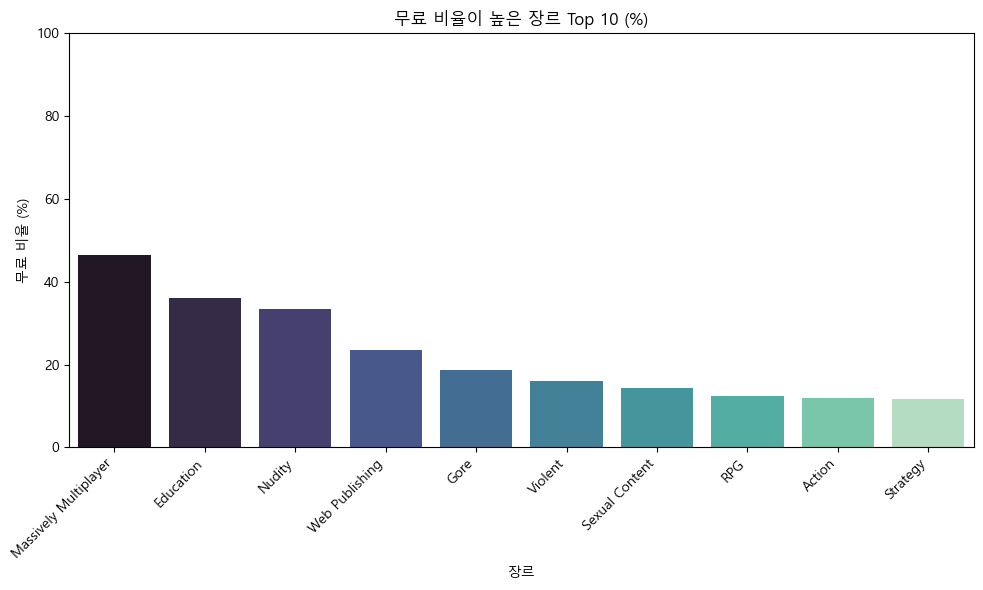

In [263]:
# 1. 무료/유료 라벨 정리
df['is_free_label'] = df['is_free'].replace({True: '무료', False: '유료'})

# 2. 장르 explode
genre_exploded_df = df.copy()
genre_exploded_df['genres_parsed'] = genre_exploded_df['genres_parsed'].str.split(', ')
genre_exploded_df = genre_exploded_df.explode('genres_parsed')

# 3. 비게임성 장르 제외
non_game_genres = [
    "Free To Play", "Early Access", "Utilities", "Photo Editing", "Video Production",
    "Software Training", "Animation & Modeling", "Design & Illustration", "Game Development", 
    "Audio Production"
]
genre_exploded_df = genre_exploded_df[
    ~genre_exploded_df['genres_parsed'].isin(non_game_genres)
]

# 무료 비율 계산
genre_total = genre_exploded_df['genres_parsed'].value_counts().reset_index()
genre_total.columns = ['genre', 'total_count']

genre_free = genre_exploded_df[genre_exploded_df['is_free'] == True]['genres_parsed'].value_counts().reset_index()
genre_free.columns = ['genre', 'free_count']

genre_ratio = pd.merge(genre_total, genre_free, on='genre', how='left')
genre_ratio['free_count'] = genre_ratio['free_count'].fillna(0)
genre_ratio['free_ratio'] = (genre_ratio['free_count'] / genre_ratio['total_count'] * 100).round(1)

# 무료 비율 상위 10개
genre_ratio_free_top = genre_ratio.sort_values(by='free_ratio', ascending=False).head(10)

# 무료 비율 시각화
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=genre_ratio_free_top,
    x='genre',
    y='free_ratio',
    hue='genre',
    palette='mako',
    dodge=False,
    legend=False
)

plt.ylim(0, 100)  # 🔥 y축 범위 고정
plt.title("무료 비율이 높은 장르 Top 10 (%)")
plt.ylabel("무료 비율 (%)")
plt.xlabel("장르")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

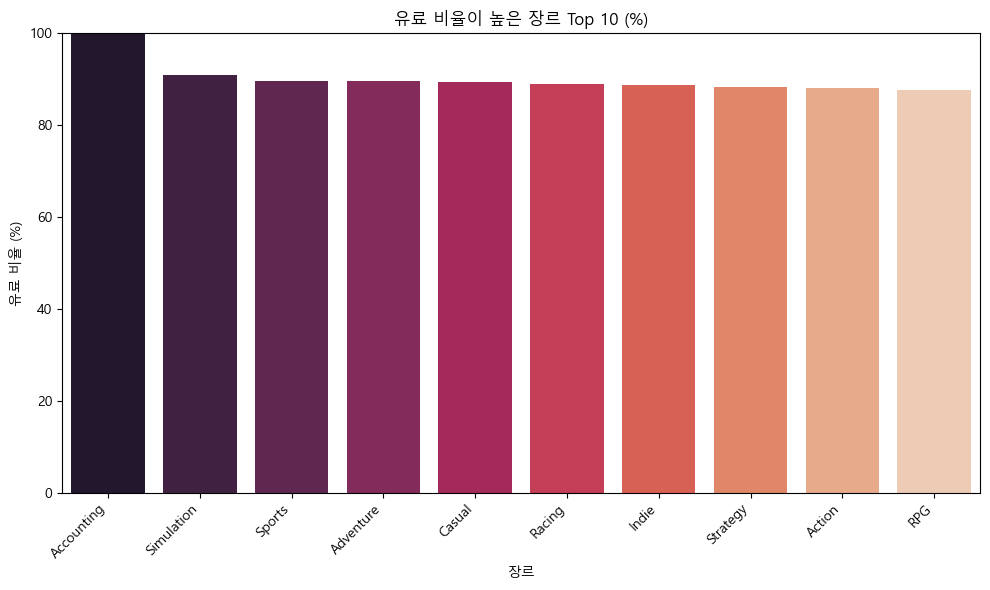

In [261]:
# 유료 비율 계산
genre_ratio['paid_ratio'] = (1 - (genre_ratio['free_count'] / genre_ratio['total_count'])) * 100
genre_ratio['paid_ratio'] = genre_ratio['paid_ratio'].round(1)

# 유료 비율 상위 10개 추출
genre_ratio_paid_top = genre_ratio.sort_values(by='paid_ratio', ascending=False).head(10)

# 유료 비율 시각화
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=genre_ratio_paid_top,
    x='genre',
    y='paid_ratio',
    hue='genre',
    palette='rocket',
    dodge=False,
    legend=False
)

plt.ylim(0, 100)  # 🔥 y축 범위 고정
plt.title("유료 비율이 높은 장르 Top 10 (%)")
plt.ylabel("유료 비율 (%)")
plt.xlabel("장르")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### 📉 3️⃣ **연속형-연속형 분석: 출시연도 vs 가격 상관관계**

출시연도(`release_year`)와 가격(`price_krw`) 사이에 상관관계가 존재하는지 파악하였습니다.

- 일반적으로 출시 연도가 더 최근일수록 높은 가격을 가질 것으로 예상하나,
- 실제로는 **거의 무상관(상관계수 ≒ 0)** 으로 나타났습니다.

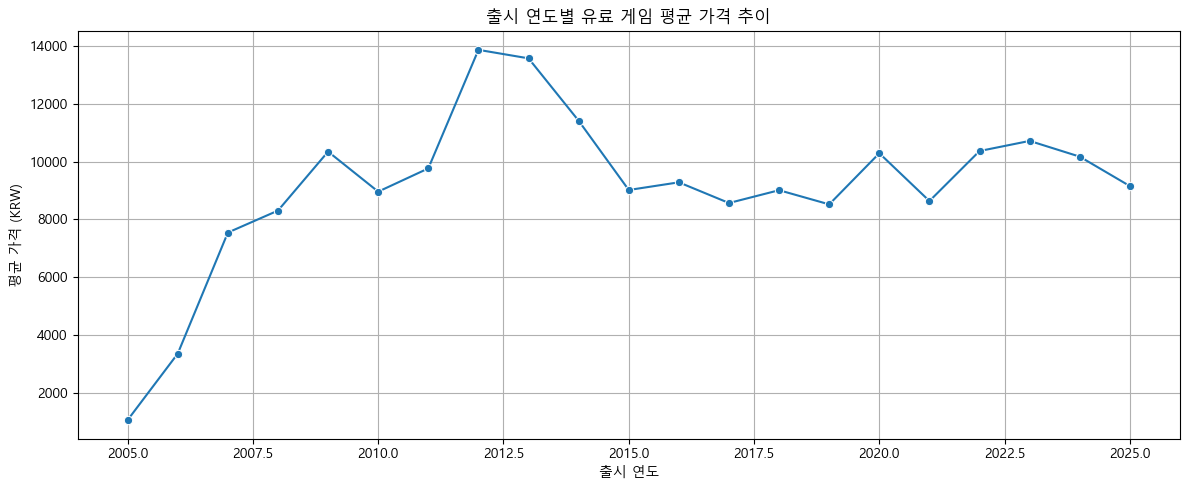

In [124]:
# 연도별 평균 가격 (유료만)
year_price = df[(df['is_free'] == False) & (df['price_krw'] > 0)].copy()
year_avg = year_price.groupby('release_year')['price_krw'].mean().round(2)

plt.figure(figsize=(12, 5))
sns.lineplot(x=year_avg.index, y=year_avg.values, marker="o")
plt.title("출시 연도별 유료 게임 평균 가격 추이")
plt.xlabel("출시 연도")
plt.ylabel("평균 가격 (KRW)")
plt.grid(True)
plt.tight_layout()
plt.show()

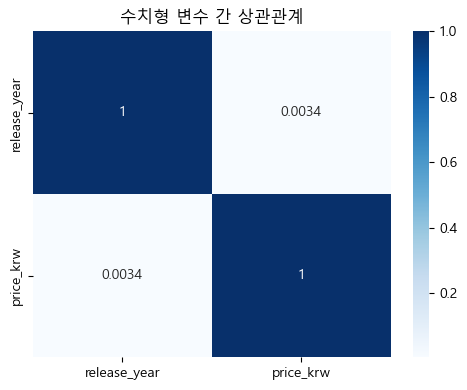

In [122]:
# 상관계수 계산
corr = df[['release_year', 'price_krw']].corr()

# 시각화
plt.figure(figsize=(5, 4))
sns.heatmap(corr, annot=True, cmap='Blues')
plt.title("수치형 변수 간 상관관계")
plt.tight_layout()
plt.show()

## 📊 6️⃣ **데이터 시각화**

본 섹션에서는 앞서 탐색 및 분석한 데이터를 시각적으로 정리하였습니다.  
분포, 가격대, 장르 특성, 유/무료 비율 등을 한눈에 파악할 수 있도록 PNG 이미지로 요약하였습니다.

1. 출시 연도별 게임 수 분포
2. 전체 무료 vs 유료 게임 비율
3. 유료 게임의 가격대별 분포
4. 자주 등장하는 장르 상위 15개
5. 장르별 무료 비율 (Top/Bottom 10)
6. 장르별 평균 가격 (Top/Bottom 10)
7. (선택) 출시 연도별 평균 가격 추이

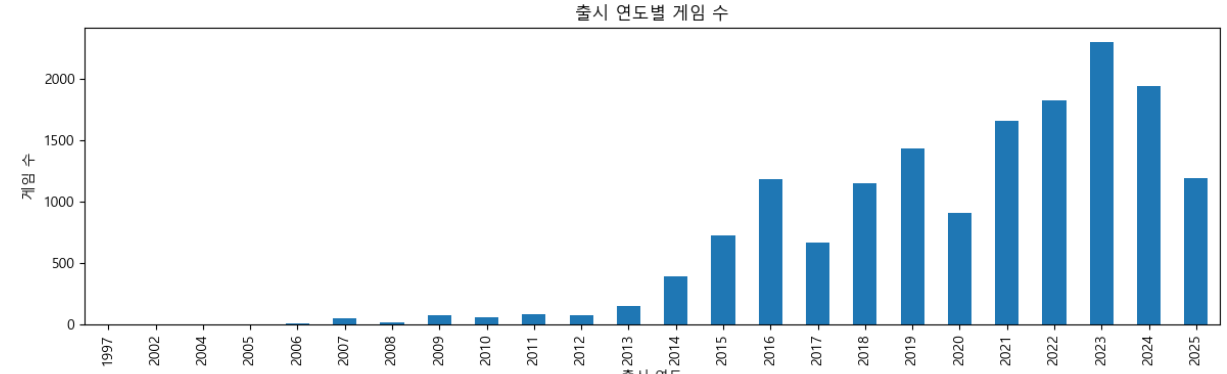   
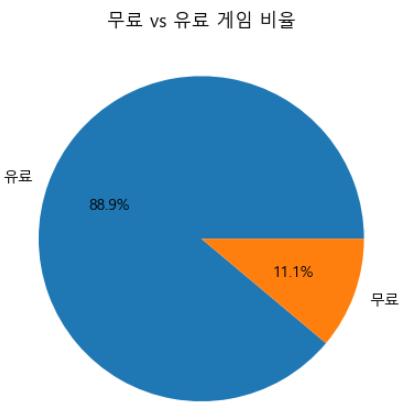   
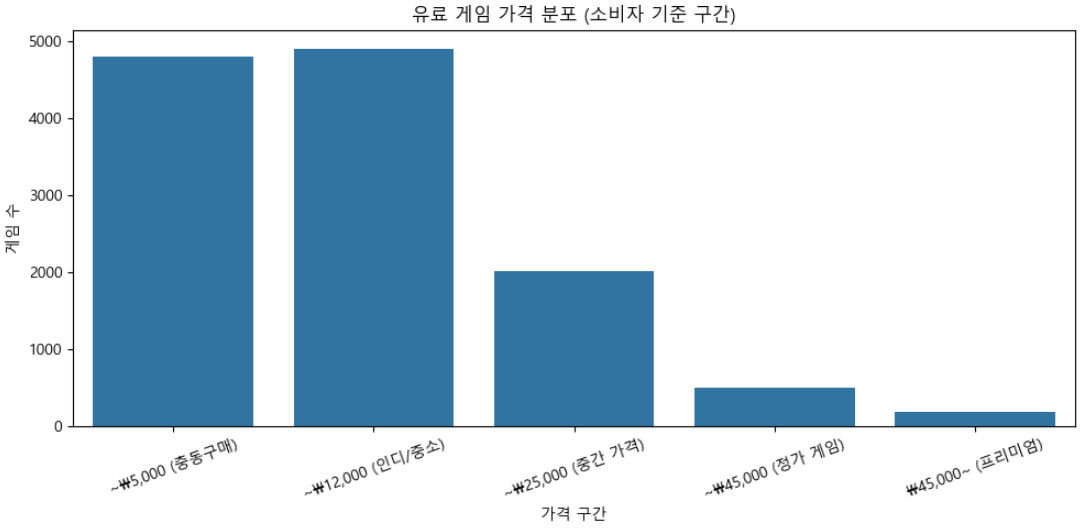   
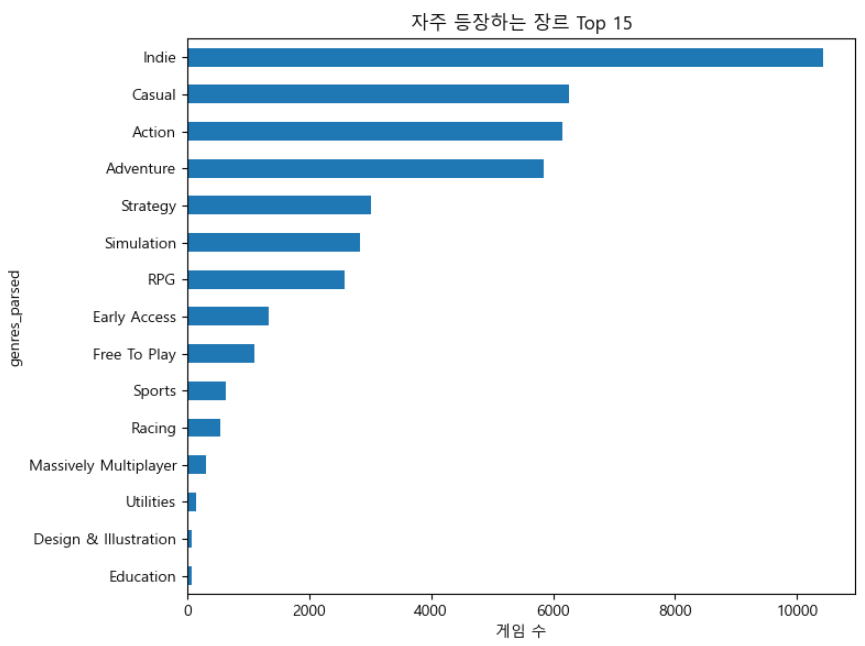   
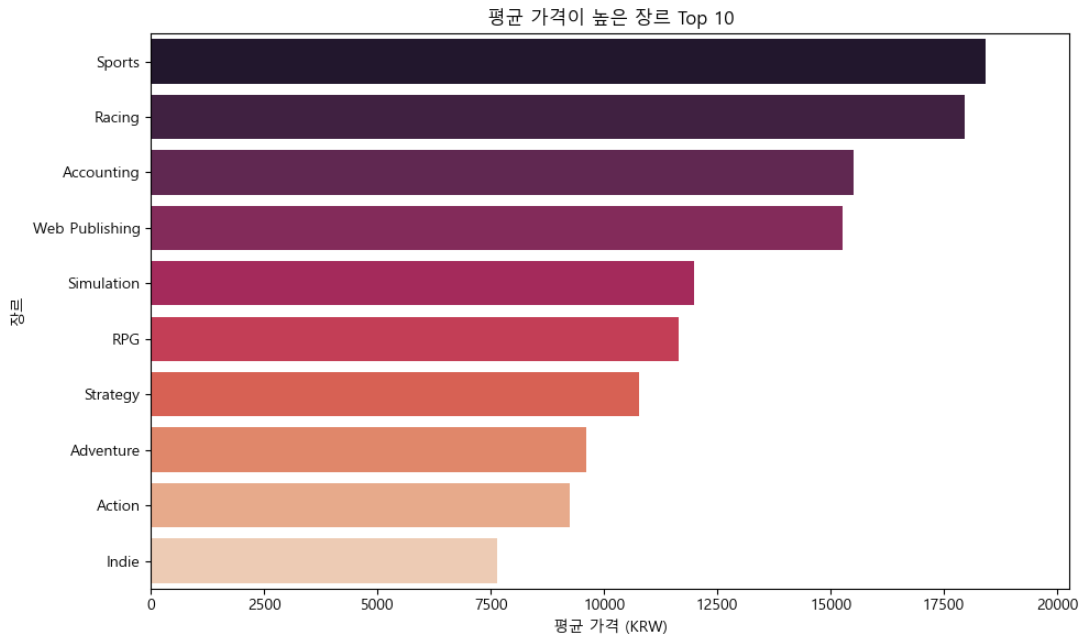   
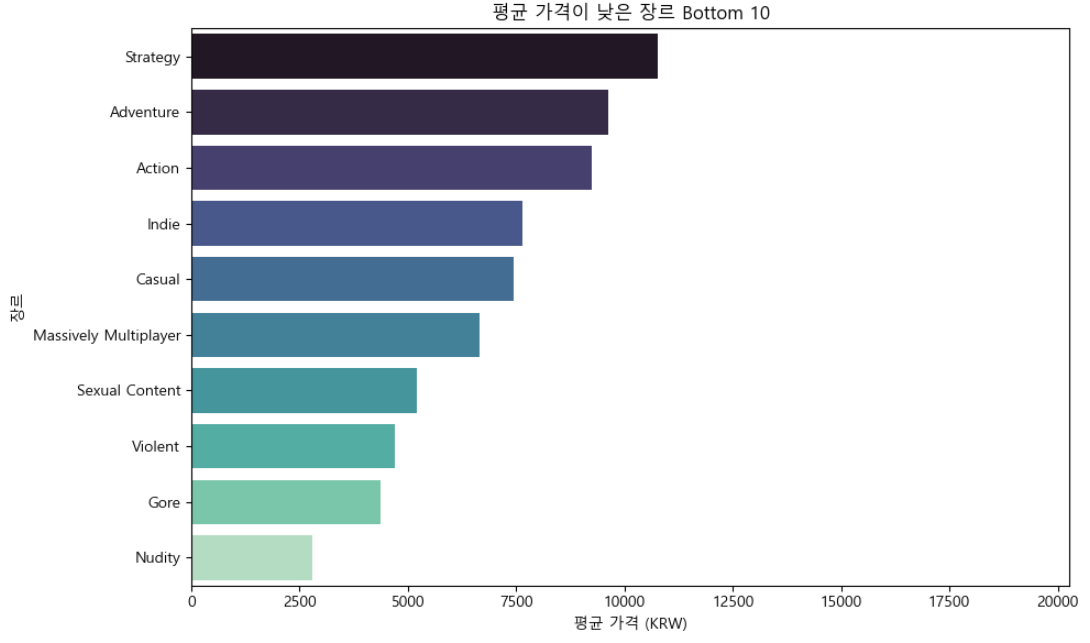   
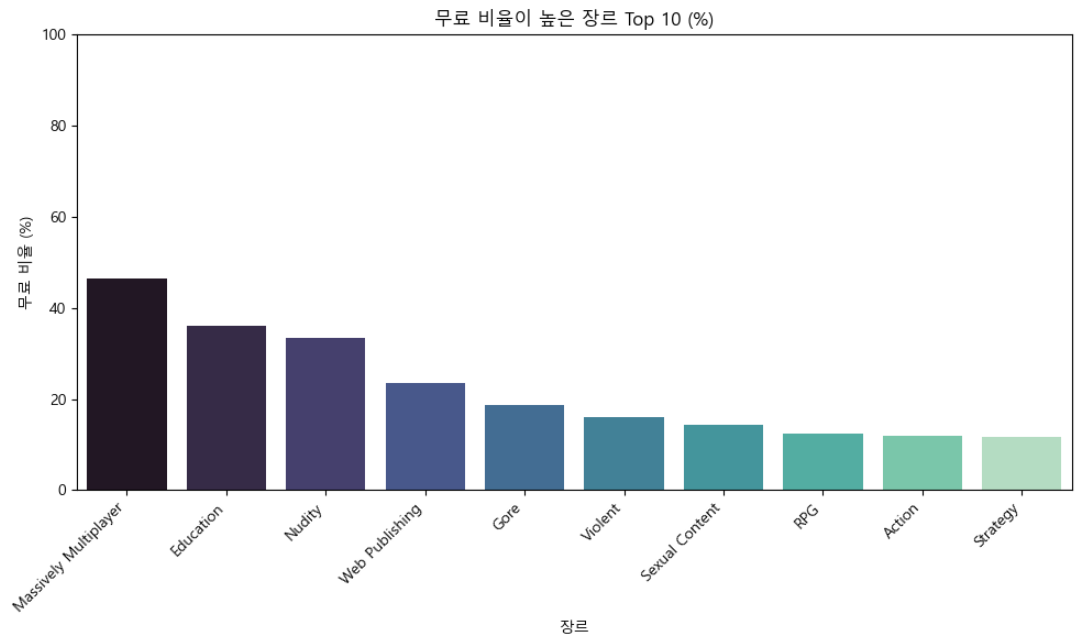   
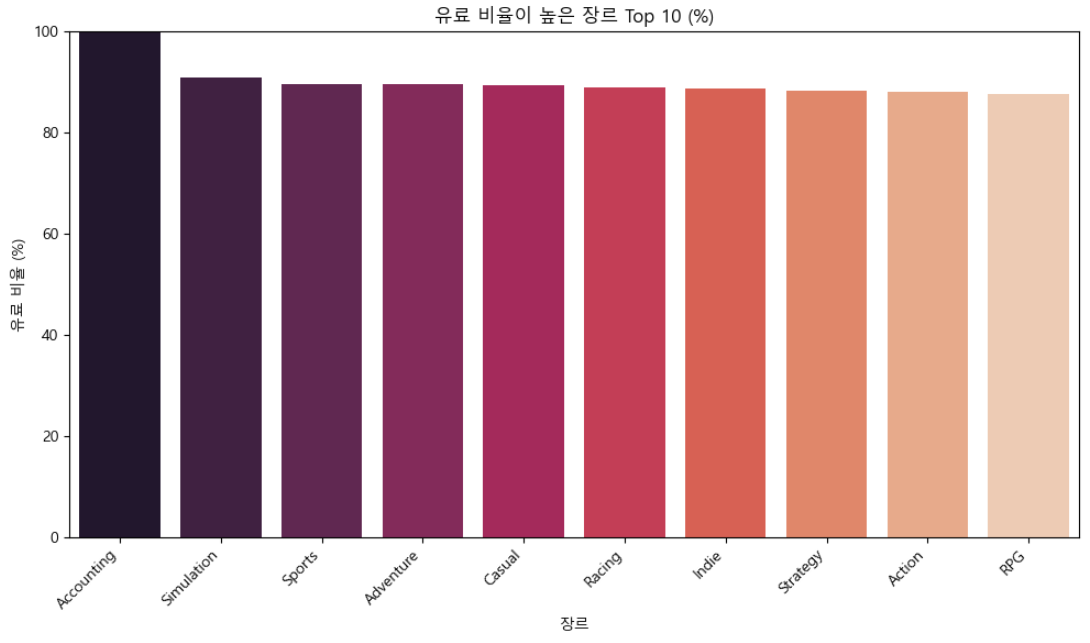   
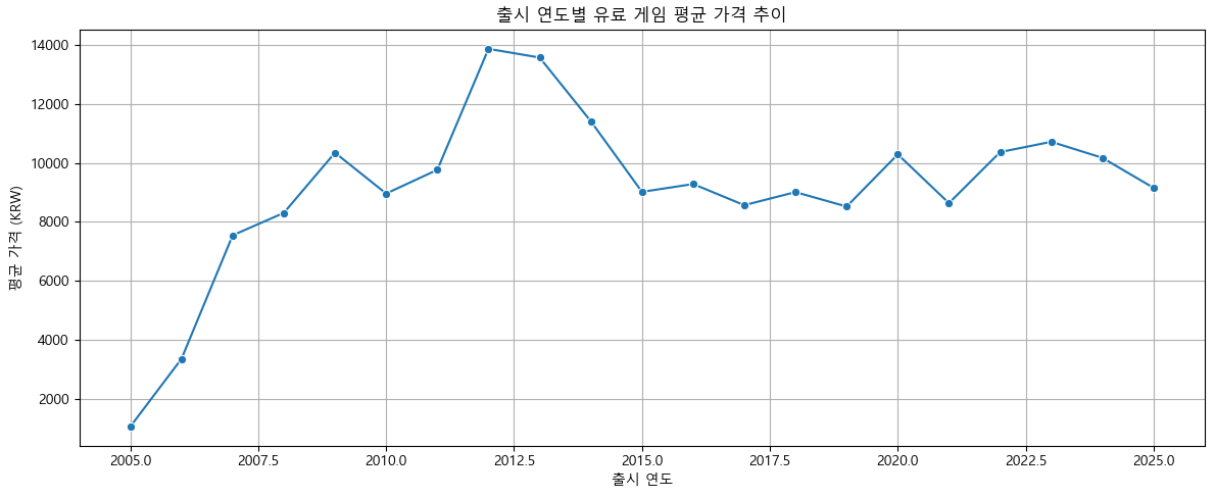

## 🌟 **7. 데이터 또는 분석 과정 차별화 포인트**

본 프로젝트는 단순한 데이터 수집 및 분석을 넘어, **Steam 플랫폼 특성과 실무적인 데이터 품질 문제까지 반영한 차별화된 접근**을 시도하였습니다.

---

### ✅ **수집 차별화: Steam API + 크롤링 혼합 전략**

- 공식 API로 AppID 전체 목록 (20만 개 이상) 확보
- 반복 요청으로 인한 차단 발생 → 웹 크롤링(Selenium, BeautifulSoup)으로 보완 시도
- IP 차단으로 중단 → **기존 2만 개 확보 데이터 기반으로 분석 방향 전환**
- **텍스트 인코딩 오류 복구**를 위한 `UTF-8-sig` 기반 이름 정제 로직 적용

---

### ✅ **클린징 차별화: 구조 파악 + 사용자 정의 전처리**

- `release_date` 문자열 → `datetime`으로 변환 → 시계열 분석 가능
- `genres` → 문자열 분해 및 불필요 장르 정제
  - **Free To Play**, **Early Access**, **Software Training** 등은 **게임이 아닌 태그**로 판단하여 제거
- `price_overview` → 가격 정보 파싱 → `price_krw` 컬럼 수치화

---

### ✅ **분석 차별화: 단일 변수 → 다변수 관계 분석까지**

- 기본 탐색 → 가격/출시일/장르/무료여부 기반으로 다양한 단일변수 탐색 수행
- 고급 분석:
  - **범주형-범주형**: 장르별 무료 비율, 유료 비율 분포 분석
  - **범주형-연속형**: 장르별 평균 가격
  - **연속형-연속형**: 출시 연도별 가격 추세, 상관 관계 분석
- **장르 파생 및 정제 후 분석 재수행** → 분석 신뢰도 및 해석력 상승

---

### ✅ **시각화 차별화: 수요 기반 가격 구간, 직관적 분포 해석**

- **5천원 단위 구간 분석** 대신, **Steam 소비자 구매행동 기반 가격 구간 재정의**:
  - ~₩5,000: 충동구매 구간
  - ~₩12,000: 중소 인디 게임
  - ~₩25,000: 일반 출시 게임
  - ~₩45,000: 정가 게임
  - ₩45,000~: AAA급 / 프리미엄 게임
- 각 구간별 유료 게임 수 및 평균 가격 시각화

---

### 📌 **결론**

Steam 플랫폼은 단순 게임 데이터 분석을 넘어서 **장르, 출시 방식, 가격 전략**이 복합적으로 작용하는 **상업적 생태계**입니다.  
따라서 이 프로젝트는 기술적 분석을 넘어서 **사용자 경험, 유통 전략, 실제 소비자 행동을 고려한 데이터 분석**을 지향하였습니다.


## 📘 **8. 데이터 분석 수업을 마감하며**

이번 프로젝트를 통해 단순한 프로그래밍을 넘어서, **실무와 같은 문제 해결 경험**을 쌓을 수 있었습니다.

Steam 플랫폼에서의 데이터 수집은 단순한 API 호출로 끝나지 않았고, 실제로는 다음과 같은 현실적인 문제들이 뒤따랐습니다:

- 지나친 요청으로 인한 서버 차단 + 크롤링 으로 인한 IP 차단 (403 Forbidden)
- CSV 인코딩 오류로 인해 게임 이름이 깨지는 문제
- 실제 게임이 아닌 유틸리티, 툴 등이 함께 포함된 원시 데이터
- 장르가 리스트 형식으로 저장되어 분석이 어려운 구조

이러한 상황들을 직접 겪으며, 수업 시간에 배운 **데이터 전처리와 정제의 중요성**을 몸소 느낄 수 있었고,    
실제 업무에서도 이러한 **예외 처리를 얼마나 꼼꼼히 해야 하는지** 실감했습니다.

또한, 단순히 데이터를 처리하는 기술보다 **어떻게 해석하고 의사결정에 연결할 수 있을지 고민하는 능력**이 더욱 중요하다는 것도 깨달았습니다.

마지막으로, 교수님께서 수업 내내 강조해주신 “**태도와 자세**”의 중요성을 다시 한 번 되새겼습니다.  
지금까지 배운 지식이 끝이 아니라는 점, 그리고 실제 산업 현장에서는 문제를 끝까지 책임지고 해결하려는 자세가 가장 중요하다는 점을 명심하겠습니다.

진심으로 감사드립니다.

---

## 🤖 **9. AI 시대, 우리들의 미래는?**

교수님께서 말씀하신 것처럼, 지금은 그 어느 때보다 **빠르게 변화하는 시대**입니다.

AI 기술의 발전은 우리가 어떤 직업을 가질 수 있을지, 어떤 역량이 요구될지를 끊임없이 바꾸고 있으며,  
지금 배우고 있는 이 기술조차 불과 몇 년 뒤에는 구식이 될 수도 있다는 사실을 부정할 수 없습니다.

하지만 그 속에서도 변하지 않는 것이 있다면,  
그건 **사람을 위한 기술**, 그리고 **의미 있는 문제를 정의하고 해결하려는 태도**일 것입니다.

이번 프로젝트를 통해, 저는 단지 데이터를 다루는 기술자가 아니라,  
앞으로 **어떤 가치를 창출할 수 있는 사람이어야 하는지**에 대해 고민할 수 있었습니다.

AI가 사람을 대체하는 것이 아니라,  
**사람의 가치를 확장시켜주는 도구로 활용될 수 있도록**  
저는 앞으로도 성실하게 배우고, 겸손하게 성장해나가겠습니다.

앞으로 어떤 길을 가든,  
교수님께서 수업 중에 강조하신 **“진심을 담아 문제를 해결하는 태도”** 를 잊지 않고 살아가겠습니다.